# Imports

In [1]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

#for memory tracking

import resource # For memory tracking

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


In [2]:
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

In [3]:
import time, json, math, random
import numpy as np
import pandas as pd
import keras as keras
import keras_hub as kh            # if your env uses keras-nlp: `import keras_nlp as kh`
from datasets import load_dataset, Dataset, Features, ClassLabel, Value
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import f1_score # Added this line
#import evaluate

In [37]:
import time
import resource # Added for memory tracking
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit



results = {}


# -------------------------------------------------------------------
# Utility: nice time formatting
# -------------------------------------------------------------------
def _format_hms(seconds: float) -> str:
    seconds = int(seconds)
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    if h > 0:
        return f"{h}h {m:02d}m {s:02d}s"
    else:
        return f"{m}m {s:02d}s"


# -------------------------------------------------------------------
# Plot learning curves + record best result
# -------------------------------------------------------------------
def plot_learning_curves(
    history,
    title: str,
    metric: str = "accuracy",
    results_dict: dict | None = None,
    verbose: bool = True,
):
    """
    Plot train/val loss and a primary metric (e.g., accuracy),
    highlight the epoch with minimum val_loss, and optionally
    store the metric@min(val_loss) in results_dict[title].
    """
    hist = history.history
    if "val_loss" not in hist:
        raise ValueError("History does not contain 'val_loss' – cannot plot learning curves.")

    val_losses = hist["val_loss"]
    epochs = range(1, len(val_losses) + 1)

    # Epoch of minimum validation loss (this is our reference point)
    min_val_loss = float(np.min(val_losses))
    min_val_epoch = int(np.argmin(val_losses))  # 0-based
    val_metric_name = f"val_{metric}"

    if val_metric_name in hist:
        val_metric_at_min_loss = float(hist[val_metric_name][min_val_epoch])
    else:
        val_metric_at_min_loss = np.nan

    # --- Figure with 2 subplots: loss + metric ---
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Loss
    axs[0].plot(epochs, hist.get("loss", []), label="train loss")
    axs[0].plot(epochs, hist["val_loss"], label="val loss")
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color="red", marker="x",
                   s=50, label="min val loss")
    axs[0].set_title(f"{title} - Loss")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Metric (accuracy by default)
    if metric in hist and val_metric_name in hist:
        axs[1].plot(epochs, hist[metric], label=f"train {metric}")
        axs[1].plot(epochs, hist[val_metric_name], label=f"val {metric}")
        axs[1].scatter(
            min_val_epoch + 1,
            val_metric_at_min_loss,
            color="red",
            marker="x",
            s=50,
            label=f"{metric} @ min val loss",
        )
    else:
        axs[1].plot(epochs, hist.get("loss", []), label="train (loss)")
        axs[1].plot(epochs, hist["val_loss"], label="val (loss)")

    axs[1].set_title(f"{title} - {metric.capitalize()}")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel(metric.capitalize())
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)  # OK for accuracy-like metrics; harmless otherwise

    plt.tight_layout()
    plt.show()

    if verbose:
        final_tr_loss = hist["loss"][-1] if "loss" in hist else float("nan")
        final_val_loss = hist["val_loss"][-1]
        final_tr_metric = hist.get(metric, [np.nan])[-1]
        final_val_metric = hist.get(val_metric_name, [np.nan])[-1]

        print(f"Final Training Loss:            {final_tr_loss:.4f}")
        print(f"Final Training {metric:>9}:    {final_tr_metric:.4f}")
        print(f"Final Validation Loss:          {final_val_loss:.4f}")
        print(f"Final Validation {metric:>9}:  {final_val_metric:.4f}")
        print(f"Min Validation Loss:            {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        if not np.isnan(val_metric_at_min_loss):
            print(f"{metric.capitalize()} @ Min Val Loss:      {val_metric_at_min_loss:.4f}")

    # Optionally store results
    summary = {
        "title": title,
        "best_epoch_by_val_loss": min_val_epoch + 1,  # 1-based
        "min_val_loss": min_val_loss,
        f"{metric}_at_min_val_loss": val_metric_at_min_loss,
    }

    if results_dict is not None:
        results_dict[title] = summary

    return summary


def print_results(results_dict: dict, sort_by: str = "accuracy_at_min_val_loss", descending: bool = True):
    """
    Pretty-print a collection of results saved from plot_learning_curves / train_and_test.

    sort_by can be e.g. "accuracy_at_min_val_loss" for accuracy-based models
    or any key that exists in the stored summary dicts.
    """
    if not results_dict:
        print("No results to display.")
        return

    # Figure out which key to sort by. If requested key isn't present, fall back to first numeric key.
    first_summary = next(iter(results_dict.values()))
    if sort_by not in first_summary:
        # try to pick a plausible numeric key
        numeric_keys = [k for k, v in first_summary.items() if isinstance(v, (int, float))]
        sort_by = numeric_keys[0] if numeric_keys else "best_epoch_by_val_loss"

    print(f"Sorting results by: {sort_by}\n")
    for title, summary in sorted(
        results_dict.items(),
        key=lambda kv: kv[1].get(sort_by, float("-inf")),
        reverse=descending,
    ):
        metric_val = summary.get(sort_by, float("nan"))
        best_epoch = summary.get("best_epoch_by_val_loss", "?")
        print(f"{title:<40}  {metric_val:.4f}  (best epoch={best_epoch})")


# -------------------------------------------------------------------
# Helper: detect single-label classification for stratified split
# -------------------------------------------------------------------
def _is_single_label_classification(y, max_classes_for_stratify: int = 50) -> bool:
    """
    Heuristic: stratify only if y is 1D, integer/bool-like, and not too many classes.
    """
    y = np.asarray(y)
    if y.ndim != 1:
        return False

    if np.issubdtype(y.dtype, (np.integer, np.bool_)):
        pass
    else:
        # floats might still be ints (e.g., 0., 1.) — check it
        if not np.all(np.equal(np.mod(y, 1), 0)):
            return False
        y = y.astype(int)

    n_classes = np.unique(y).size
    return 2 <= n_classes <= max_classes_for_stratify


# -------------------------------------------------------------------
# Generic train + test wrapper
# -------------------------------------------------------------------
def train_and_test(
    model: tf.keras.Model,
    *,
    X_train,
    y_train,
    X_val=None,
    y_val=None,
    X_test=None,
    y_test=None,
    epochs: int = 100,
    batch_size: int = 128,
    loss: str | tf.keras.losses.Loss = "sparse_categorical_crossentropy",
    metrics=("accuracy",),
    optimizer: tf.keras.optimizers.Optimizer | None = None,
    learning_rate: float = 1e-3,
    clipnorm: float | None = None,
    validation_split: float = 0.0,
    random_state: int = 42,
    title: str = "Model",
    use_early_stopping: bool = True,
    patience: int = 10,
    min_delta: float = 1e-4,
    use_reduce_lr: bool = False,
    reduce_lr_params: dict | None = None,
    extra_callbacks: list | None = None,
    class_weight: dict | None = None,
    verbose: int = 1,
    metric_for_curves: str = "accuracy",
    results_dict: dict | None = None,
    return_history: bool = False,
):
    """
    Fit a Keras model, optionally create/stratify a validation set,
    plot learning curves, evaluate on test, and record a summary.

    Returns:
        summary dict (and optionally the Keras History object).
    """

    if X_train is None or y_train is None:
        raise ValueError("X_train and y_train must be provided.")

    if X_test is None or y_test is None:
        raise ValueError("X_test and y_test must be provided.")

    # Create internal validation split if needed and requested
    made_internal_val = False
    if (X_val is None or y_val is None) and validation_split and validation_split > 0.0:
        X_tr = np.asarray(X_train)
        y_tr = np.asarray(y_train)
        test_size = float(validation_split)

        if _is_single_label_classification(y_tr):
            splitter = StratifiedShuffleSplit(
                n_splits=1, test_size=test_size, random_state=random_state
            )
            (train_idx, val_idx), = splitter.split(X_tr, y_tr)
        else:
            splitter = ShuffleSplit(
                n_splits=1, test_size=test_size, random_state=random_state
            )
            (train_idx, val_idx), = splitter.split(np.arange(len(X_tr)))

        X_train, y_train = X_tr[train_idx], y_tr[train_idx]
        X_val,   y_val   = X_tr[val_idx],   y_tr[val_idx]
        made_internal_val = True

    # Compile model
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)

    model.compile(optimizer=optimizer, loss=loss, metrics=list(metrics))

    # Callbacks
    callbacks = extra_callbacks[:] if extra_callbacks is not None else []

    if use_early_stopping:
        callbacks.append(
            EarlyStopping(
                monitor="val_loss",
                patience=patience,
                min_delta=1e-4,
                restore_best_weights=True,
                verbose=verbose,
            )
        )

    if use_reduce_lr:
        if reduce_lr_params is None:
            reduce_lr_params = dict(
                monitor="val_loss",
                factor=0.5,
                patience=5,
                min_delta=1e-4,
                cooldown=0,
                min_lr=1e-8,
                verbose=verbose,
            )
        callbacks.append(ReduceLROnPlateau(**reduce_lr_params))

    # Fit
    if title:
        print(f"\n=== {title} ===\n")

    # Capture peak memory before training (this is cumulative max RSS for the process)
    # On Linux (Colab), ru_maxrss is in kilobytes.
    memory_before_train_kb = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

    fit_kwargs = dict(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        shuffle=True,
        verbose=verbose,
        class_weight=class_weight,
    )

    if X_val is not None and y_val is not None:
        fit_kwargs["validation_data"] = (X_val, y_val)

    start = time.time()
    history = model.fit(**fit_kwargs)
    end = time.time()

    # Capture peak memory after training, this will be the peak reached during training
    peak_memory_kb = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    peak_memory_mb = peak_memory_kb / 1024 # Convert to MB

    # Learning curves + summary keyed by val_loss
    curves_summary = plot_learning_curves(
        history,
        title=title,
        metric=metric_for_curves,
        results_dict=results_dict,
        verbose=True,
    )

    # Evaluate on test
    test_out = model.evaluate(X_test, y_test, verbose=0)

    # Ensure test_results dictionary consistently uses 'loss' and 'accuracy' keys
    test_results = {}
    if len(test_out) >= 1:
        test_results['loss'] = float(test_out[0])
    if len(test_out) >= 2: # Assuming accuracy is always the second metric
        test_results['accuracy'] = float(test_out[1])
    # Additional metrics can be added dynamically if needed based on `metrics` argument
    # if len(metrics) > 1 and len(test_out) > 2:
    #     for i, metric_name in enumerate(metrics[1:]):
    #         test_results[metric_name] = float(test_out[i + 2])


    print("\nTest metrics:")
    for k, v in test_results.items():
        print(f"  {k}: {v:.4f}")

    duration = end - start
    print(f"\nExecution Time: {_format_hms(duration)}")
    print(f"Peak Memory Usage: {peak_memory_mb:.2f} MB")

    # Consolidated summary
    summary = {
        **curves_summary,
        "title": title,
        "made_internal_val": made_internal_val,
        "test_metrics": test_results,
        "train_time_sec": duration,
        "peak_memory_mb": peak_memory_mb,
    }

    # If a results_dict is provided, update that entry with test metrics too
    if results_dict is not None:
        if title in results_dict:
            results_dict[title].update(summary)
        else:
            results_dict[title] = summary

    if return_history:
        return summary, history
    return summary


# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset HuffPost, analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.**
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




### **Data loading and cleaning**

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

SUBSET_FRAC = 1.0   # set < 1.0 to downsample the pool (stratified)
MIN_WORDS   = 3     # drop rows with fewer than MIN_WORDS after cleaning

In [6]:
# #load dataset
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"

# Load full JSON as a single HF split
huff_all = load_dataset("json", data_files=URL, split="train")
print("Raw HuffPost dataset:", huff_all)
print("Columns:", huff_all.column_names)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


News_Category_Dataset_v2.json:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Raw HuffPost dataset: Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']


In [7]:
huff_all[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': datetime.datetime(2018, 5, 26, 0, 0)}

### **Lets use SpaCy to clean the data, lemmatize, tokenize remove stop words , remove puntuations, space i.e full normalization including lemmatization**





In [8]:
from tqdm import tqdm

nlp_spacy = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
STOP = spacy.lang.en.stop_words.STOP_WORDS
print(f"spaCy loaded: {nlp_spacy.pipe_names}")

#in this method we will clean the data, lemmatize, tokenize remove stop words , remove puntuations, space i.e al of normalization including lemmatization

def spacy_clean(batch):
    """
    Clean text batch using spaCy
    - Tokenize
    - Lemmatize
    - Lowercase
    - Remove stopwords and non-alphabetic tokens
    """
    # Combine headline and description
    texts = [
        str(h) + " " + str(d)
        for h, d in zip(batch["headline"], batch["short_description"])
    ]

    # Process with spaCy
    docs = list(nlp_spacy.pipe(texts, batch_size=1000))

    cleaned = []
    len_tokens = []

    for doc in docs:
        # Extract clean tokens
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        cleaned.append(" ".join(tokens))
        len_tokens.append(len(tokens))

    return {
        "text_clean": cleaned,
        "len_tokens": len_tokens
    }



spaCy loaded: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [9]:

huff_subset = huff_all            #we will use the dataset not the dataframe as thats what was given as guideline
huff_subset = huff_subset.map(
    spacy_clean,
    batched=True,
    batch_size=1000,
)

# Filter out rows where len_tokens is less than MIN_WORDS (which is 3)
before_filter = len(huff_subset)
huff_subset = huff_subset.filter(lambda x: x["len_tokens"] >= MIN_WORDS)
print(f"Removed {before_filter - len(huff_subset)} rows with < {MIN_WORDS} spaCy tokens.")
print("After spaCy token length filter:", huff_subset)

Map:   0%|          | 0/200853 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200853 [00:00<?, ? examples/s]

Removed 937 rows with < 3 spaCy tokens.
After spaCy token length filter: Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text_clean', 'len_tokens'],
    num_rows: 199916
})


### **In the above cell we are removing the rows having less than or equal to MIN_WORDS which was set to 3**

In [10]:
# lets check for the unique tokens

unique_cleaned_tokens = set()
for text in tqdm(huff_subset['text_clean']):
    for token in text.split():
        unique_cleaned_tokens.add(token)

total_unique_cleaned_tokens = len(unique_cleaned_tokens)
print(f"Total unique cleaned tokens (lemmas) from spacy_clean: {total_unique_cleaned_tokens}")

100%|██████████| 199916/199916 [00:11<00:00, 17506.44it/s]

Total unique cleaned tokens (lemmas) from spacy_clean: 78195


TF-IDF Category Overlap Analysis

 Starting TF-IDF overlap analysis...
 N-gram Range Used: (1, 3)
Thresholds:
  High: > 0.8
  Medium: > 0.6

 Dataset: 199,916 articles, 41 categories

 Computing TF-IDF similarity...

 Top 15 Most Similar Category Pairs:
#   Category 1           Category 2           Score    Status
----------------------------------------------------------------------
1   PARENTING            PARENTS              0.973     HIGH
2   HEALTHY LIVING       WELLNESS             0.971     HIGH
3   FOOD & DRINK         TASTE                0.943     HIGH
4   THE WORLDPOST        WORLD NEWS           0.926     HIGH
5   ARTS                 CULTURE & ARTS       0.892     HIGH
6   ARTS                 ARTS & CULTURE       0.836     HIGH
7   FIFTY                HEALTHY LIVING       0.828     HIGH
8   FIFTY                WELLNESS             0.812     HIGH
9   HEALTHY LIVING       IMPACT               0.810     HIGH
10  ENVIRONMENT          GREEN                0.807     HIGH
11 

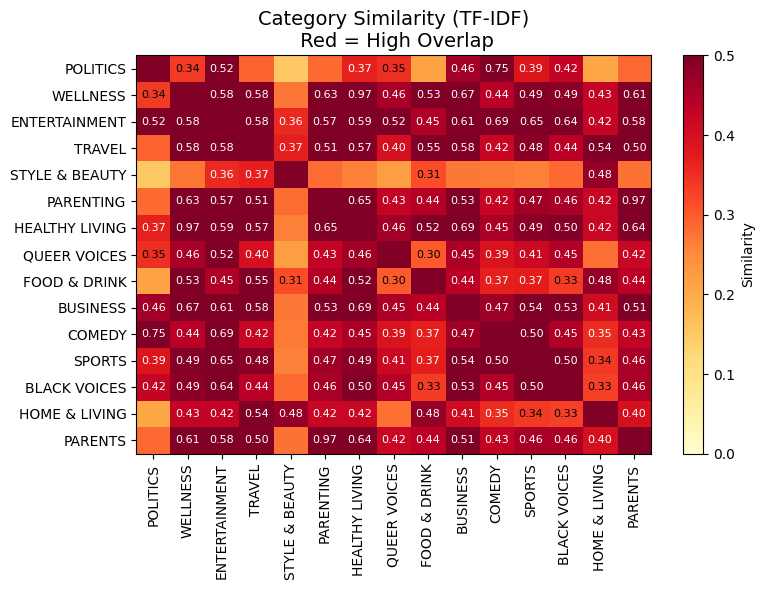

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#create these so if needed I can use it later
similarity_high_threshold = 0.8
similarity_medium_threshold = 0.6

print("TF-IDF Category Overlap Analysis")
print("=" * 70)



def tfidf_overlap(
    huff_dataset, top_n=15, ngram_range=(1, 2)
):
    """
    Analysis of category overlap using TF-IDF on cleaned text

    Parameters:
    -----------
    huff_dataset : HuggingFace Dataset or DataFrame
        spaCy-cleaned dataset with 'text_clean' column
    top_n : int
        Number of most similar pairs to show
    ngram_range : tuple (min_n, max_n)
        The lower and upper boundary of the range of n-values for different n-grams
        to be extracted. E.g., (1, 2) means unigrams and bigrams.
    """
    # change these to lower value for a smaller subset while testing the code
    similarity_high_threshold = 0.8
    similarity_medium_threshold = 0.6
    top_n_categories = 15

    print("\n Starting TF-IDF overlap analysis...")
    print(f" N-gram Range Used: {ngram_range}")

    print("Thresholds:")
    print(f"  High: > {similarity_high_threshold}")
    print(f"  Medium: > {similarity_medium_threshold}")

    # Convert to DataFrame if needed
    if hasattr(huff_dataset, "to_pandas"):
        df = huff_dataset.to_pandas()
    else:
        df = pd.DataFrame(huff_dataset)

    print(f"\n Dataset: {len(df):,} articles, {df['category'].nunique()} categories")

    text_column = "text_clean"    #this will use the new column added wwith sapce before
    # Aggregate text by category
    print("\n Computing TF-IDF similarity...")
    category_texts = (
        df.groupby("category")[text_column].apply(lambda x: " ".join(x)).to_dict()
    )
    categories = list(category_texts.keys())
    texts = [category_texts[cat] for cat in categories]

    # use tfidvectorizer with ngram to get better similarity
    vectorizer = TfidfVectorizer(max_features=1000, ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(texts)

    # find similarity using cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # find top pairs
    print(f"\n Top {top_n} Most Similar Category Pairs:")
    print("=" * 70)
    print(f"{'#':<3} {'Category 1':<20} {'Category 2':<20} {'Score':<8} {'Status'}")
    print("-" * 70)

    pairs = []
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            sim = similarity_matrix[i][j]
            if sim > 0.15:
                pairs.append((categories[i], categories[j], sim))

    pairs.sort(key=lambda x: x[2], reverse=True)

    for rank, (cat1, cat2, sim) in enumerate(pairs[:top_n], 1):      # enumerate last parameter 1 says the start index(rank) will be 1
        if sim > similarity_high_threshold:
            status = " HIGH"
        elif sim > similarity_medium_threshold:
            status = " MED"
        else:
            status = " LOW"

        print(f"{rank:<3} {cat1:<20} {cat2:<20} {sim:<8.3f} {status}")

    # Summary
    high = [p for p in pairs if p[2] > similarity_high_threshold]
    medium = [
        p for p in pairs if similarity_medium_threshold < p[2] <= similarity_high_threshold
    ]

    print(f"\n SUMMARY:")
    print(f"   High overlap (> {similarity_high_threshold}): {len(high)} pairs")
    print(
        f"   Medium overlap (> {similarity_medium_threshold}- {similarity_high_threshold}): {len(medium)} pairs"
    )

    # Get top top_n_categories  by article count
    top_cats = df["category"].value_counts().head(top_n_categories).index.tolist()
    cat_indices = [categories.index(cat) for cat in top_cats if cat in categories]

    sim_subset = similarity_matrix[np.ix_(cat_indices, cat_indices)]

    plt.figure(figsize=(8, 6))
    plt.imshow(sim_subset, cmap="YlOrRd", aspect="auto", vmin=0, vmax=0.5)
    plt.colorbar(label="Similarity")
    plt.xticks(range(len(top_cats)), top_cats, rotation=90)
    plt.yticks(range(len(top_cats)), top_cats)
    plt.title("Category Similarity (TF-IDF)\n Red = High Overlap", fontsize=14)

    # Add text for high similarities
    for i in range(len(top_cats)):
        for j in range(len(top_cats)):
            if i != j and sim_subset[i, j] > 0.3:
                plt.text(
                    j,
                    i,
                    f"{sim_subset[i, j]:.2f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="white" if sim_subset[i, j] > 0.35 else "black",
                )

    plt.tight_layout()
    plt.show()

    return pairs

pairs = tfidf_overlap(huff_subset, top_n=15, ngram_range=(1, 3))

### **The above shows the similarity(computed with upto n-gram=3) of different categories in pairs. For our threshold we consider 80% as high similairy**

In [12]:
# Extract 'len_tokens' from huff_subset and convert to a numpy array
token_lengths = np.array(huff_subset["len_tokens"], dtype=np.int32)

# Calculate the quantiles
quantiles_spacy_doc = np.quantile(token_lengths, [0.5, 0.9, 0.95, 0.99])

print("Token length quantiles (spaCy tokens):")
print(f"50%: {quantiles_spacy_doc[0]:.1f}, 90%: {quantiles_spacy_doc[1]:.1f}, 95%: {quantiles_spacy_doc[2]:.1f}, 99%: {quantiles_spacy_doc[3]:.1f}")

Token length quantiles (spaCy tokens):
50%: 15.0, 90%: 24.0, 95%: 27.0, 99%: 33.0


In [13]:
# reverse to apply bottom→top priority and then create an updated subet
# for now keeping a seprated DF so as we can compare  later we can over write

# Select only pairs with a high similarity threshold, then reverse them


filtered_pairs = [p for p in pairs if p[2] > similarity_high_threshold]

pairs_for_mapping = list(reversed(filtered_pairs))
mapping = {}
for c1, c2, score in pairs_for_mapping:
    mapping[c2] = c1

sorted_mapped_huff_df = huff_subset.to_pandas()

# Intentionaly running the below line twice as there could mapping done in first round which else will not get covered as I am not doing a check.. Deb
sorted_mapped_huff_df["category"] = sorted_mapped_huff_df["category"].replace(mapping)
sorted_mapped_huff_df["category"] = sorted_mapped_huff_df["category"].replace(mapping)

# lets create a copy of the dataset from dataframe
huff_new =Dataset.from_pandas(sorted_mapped_huff_df)




### **The above step completes mapping of columns with similarity score (cosine similairy of 0.8 and above)**



In [14]:
huff_new.column_names

['category',
 'headline',
 'authors',
 'link',
 'short_description',
 'date',
 'text_clean',
 'len_tokens']

In [15]:
# Optional stratified downsample to keep runtime manageable
# if 0.0 < SUBSET_FRAC < 1.0:
#     subset = huff_all.train_test_split(
#         train_size=SUBSET_FRAC,
#         seed=SEED,
#         stratify_by_column="category",
#     )
#     huff_all = subset["train"]
#     print(f"After SUBSET_FRAC={SUBSET_FRAC}: {len(huff_all)} rows")

In [16]:
# drop all columns of huff_new except category and text_clean and assign to huff
huff = huff_new.remove_columns(
    [col for col in huff_new.column_names if col not in ("category", "text_clean")]
)
huff = huff.rename_column("text_clean", "text")

In [17]:
#huff.shape

In [18]:
# De-duplicate on text and drop ambiguous texts (same text with >1 label)
df = huff.to_pandas()[["text", "category"]]

# 1) drop exact duplicate texts (keep first)
df = df.drop_duplicates(subset=["text"], keep="first")

# 2) drop texts that still appear with multiple labels (ambiguous)
label_counts_per_text = df.groupby("text")["category"].nunique()
ambiguous_texts = label_counts_per_text[label_counts_per_text > 1].index
df = df[~df["text"].isin(ambiguous_texts)].reset_index(drop=True)

huff = Dataset.from_pandas(df, preserve_index=False)
print("After text-only dedupe + drop ambiguities:", len(huff))

After text-only dedupe + drop ambiguities: 199146


### **Above step completed the de-duplication and removal of ambiguous text**

In [19]:
# Show a few cleaned examples
for i in range(3):
    print(f"[{i}] - (label={huff[i]['category']}).. {huff[i]['text'][:200]} ")

[0] - (label=CRIME).. mass shootings texas week tv leave husband kill child day america 
[1] - (label=ENTERTAINMENT).. smith joins diplo nicky jam world cup official song course song 
[2] - (label=ENTERTAINMENT).. hugh grant marries time age actor longtime girlfriend anna eberstein tie knot civil ceremony 


### **The above step shows the tokens by record with removed stop words , lemmatized ,removed punctuations , removed spaces**

In [20]:
from collections import Counter

# Get all category labels from the 'huff' dataset
categories = huff["category"]

# Use Counter to count the occurrences of each category
category_counts = Counter(categories)
print(f"total categories are {len(category_counts)}")
print("Category Counts in the huff dataset:")
# Iterate through the most common categories for a sorted, readable output
for category, count in category_counts.most_common():
    print(f"- {category}: {count}")



total categories are 30
Category Counts in the huff dataset:
- POLITICS: 32447
- FIFTY: 29101
- ENTERTAINMENT: 17125
- PARENTING: 12530
- TRAVEL: 9842
- STYLE & BEAUTY: 9491
- FOOD & DRINK: 8305
- QUEER VOICES: 6285
- BUSINESS: 5894
- THE WORLDPOST: 5839
- COMEDY: 5001
- SPORTS: 4857
- BLACK VOICES: 4514
- HOME & LIVING: 4159
- GOOD NEWS: 4047
- ENVIRONMENT: 3916
- ARTS: 3850
- WEDDINGS: 3651
- DIVORCE: 3423
- CRIME: 3393
- WOMEN: 3363
- MEDIA: 2807
- WORLDPOST: 2536
- RELIGION: 2523
- STYLE: 2216
- SCIENCE: 2169
- TECH: 2029
- MONEY: 1706
- COLLEGE: 1136
- EDUCATION: 991


### **We will use 99 percentile data available from quantiles_spacy_doc index position 3 else the tokens without stopwords has 99 percentile of 33 and we will lose lot of information**

In [21]:
MAX_LEN = int(quantiles_spacy_doc[3])
MAX_LEN

33

### **Reproducible Splits Section**

In [22]:
from datasets import Dataset, Features, ClassLabel, Value
from sklearn.model_selection import train_test_split

# Map string labels -> integer IDs
# get unique label names and map each to an integer so we have numeric targets
label_names = sorted(set(huff["category"]))
label2id = {lab: i for i, lab in enumerate(label_names)}
id2label = {i: lab for lab, i in label2id.items()}
print("Number of labels:", len(label_names))


# Add the label (integer column) to the dataset
def _encode_labels(batch):
    batch["label"] = [label2id[c] for c in batch["category"]]
    return batch

huff_encoded = huff.map(_encode_labels, batched=True) #original dataset + label column

features = Features(
    {
        "text":  Value("string"),
        "label": ClassLabel(num_classes=len(label_names), names=label_names),
    }
)

# create new dataset with text(cleaned text field) and label (integer class id)
all_ds = Dataset.from_dict(
    {"text": huff_encoded["text"], "label": huff_encoded["label"]},
    features=features,
)
print("All_ds:", all_ds)

Number of labels: 30


Map:   0%|          | 0/199146 [00:00<?, ? examples/s]

All_ds: Dataset({
    features: ['text', 'label'],
    num_rows: 199146
})


### **Train/Validation/Test Splits (80/10/10, stratified)**

In [23]:
# Build stratified 80/10/10 splits using sklearn
y_all = np.array(all_ds["label"])
idx   = np.arange(len(y_all))

In [24]:
# 80/10/10 split indices
train_idx, tmp_idx, y_tr, y_tmp = train_test_split(
    idx,
    y_all,
    test_size=0.20,
    random_state=SEED,
    stratify=y_all,
)
val_idx, test_idx, y_va, y_te = train_test_split(
    tmp_idx,
    y_tmp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_tmp,
)

train_ds = all_ds.select(train_idx.tolist())
val_ds   = all_ds.select(val_idx.tolist())
test_ds  = all_ds.select(test_idx.tolist())

print("Train size:", len(train_ds))
print("Val size:  ", len(val_ds))
print("Test size: ", len(test_ds))

Train size: 159316
Val size:   19915
Test size:  19915


In [25]:
# Keep numpy arrays ready for later models (baseline and beyond)
X_tr = np.array(train_ds["text"], dtype=object)
X_va = np.array(val_ds["text"], dtype=object)
X_te = np.array(test_ds["text"], dtype=object)

y_tr = np.array(train_ds["label"], dtype="int32")
y_va = np.array(val_ds["label"], dtype="int32")
y_te = np.array(test_ds["label"], dtype="int32")

In [26]:
y_tr[0]

np.int32(18)

In [27]:
# vocab size

vocab_size = total_unique_cleaned_tokens
print("Number of unique tokens in the training set (vocab size):", vocab_size)

Number of unique tokens in the training set (vocab size): 78195


### **TextVectorization, padding, tensors**

In [28]:
import tensorflow as tf
from tensorflow import keras

# 1) Create a TextVectorization layer
text_vec = keras.layers.TextVectorization(
    max_tokens= vocab_size,
    output_mode="int",
    output_sequence_length=MAX_LEN,  # from the spaCy length analysis (e.g., 95th percentile)
    standardize="lower_and_strip_punctuation",
    split="whitespace",  # simple whitespace tokenization
)


In [29]:
# 2) Adapt the layer on the training texts only
text_vec.adapt(X_tr)

In [30]:
# 3) Apply vectorization (+ implicit padding/truncation) to each split
X_tr_int = text_vec(X_tr)
X_va_int = text_vec(X_va)
X_te_int = text_vec(X_te)

print("Vectorized shapes (num_examples, MAX_LEN):")
print("Train:", X_tr_int.shape)
print("Val:  ", X_va_int.shape)
print("Test: ", X_te_int.shape)

Vectorized shapes (num_examples, MAX_LEN):
Train: (159316, 33)
Val:   (19915, 33)
Test:  (19915, 33)


In [31]:
# 4) Build final tensors for model input + labels

X_tr_tf = tf.convert_to_tensor(X_tr_int)
X_va_tf = tf.convert_to_tensor(X_va_int)
X_te_tf = tf.convert_to_tensor(X_te_int)

y_tr_tf = tf.convert_to_tensor(y_tr, dtype=tf.int32)
y_va_tf = tf.convert_to_tensor(y_va, dtype=tf.int32)
y_te_tf = tf.convert_to_tensor(y_te, dtype=tf.int32)

print("Example batch – first row of X_tr_tf:")
print(X_tr_tf[0])
print("Corresponding label:", y_tr_tf[0].numpy())

Example batch – first row of X_tr_tf:
tf.Tensor(
[ 5817  7170    24   485    24    10    81    49    49   734    81 24076
    24   594   903  7395   594   347   376   683  2313    55     0     0
     0     0     0     0     0     0     0     0     0], shape=(33,), dtype=int64)
Corresponding label: 18


In [32]:
X_tr_tf[0]

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([ 5817,  7170,    24,   485,    24,    10,    81,    49,    49,
         734,    81, 24076,    24,   594,   903,  7395,   594,   347,
         376,   683,  2313,    55,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])>

### **Verify truncation/padding works as intended**


In [33]:
# Verify truncation/padding works as intended

import numpy as np

def check_lengths(X_tf, X_raw, name):
    # X_tf has shape (num_examples, MAX_LEN) with 0 as padding
    arr = X_tf.numpy()
    nonpad_counts = (arr != 0).sum(axis=1)  # how many real tokens per example

    print(f"{name} vectorized shape:", arr.shape)
    print(
        f"{name} non-padding lengths: "
        f"min={nonpad_counts.min()}, max={nonpad_counts.max()}, "
        f"mean={nonpad_counts.mean():.1f}"
    )
    # Sanity check: no sequence can be longer than MAX_LEN after vectorization
    assert arr.shape[1] == MAX_LEN

    # Show an example where truncation likely happened
    idx = int(np.argmax(nonpad_counts))  # one of the longest sequences
    print("\nExample long text (raw) length:", len(X_raw[idx].split()))
    print("Example long text (after vectorization) non-pad length:", int(nonpad_counts[idx]))
    print("First 50 token IDs:", arr[idx, :50])

check_lengths(X_tr_tf, X_tr, "Train")
check_lengths(X_va_tf, X_va, "Val")
check_lengths(X_te_tf, X_te, "Test")


Train vectorized shape: (159316, 33)
Train non-padding lengths: min=3, max=33, mean=15.7

Example long text (raw) length: 37
Example long text (after vectorization) non-pad length: 33
First 50 token IDs: [ 5498 35690    45    26   292   390   337  3366 14706 10803    44     9
  4037 35690   193     6  1176    76   536   361   152   614  4073   107
  1200     2   629     6    29  1850 19823  8244  8951]
Val vectorized shape: (19915, 33)
Val non-padding lengths: min=3, max=33, mean=15.7

Example long text (raw) length: 35
Example long text (after vectorization) non-pad length: 33
First 50 token IDs: [  153  5203  1219   162   154  1117    39    11    52  7391   364    42
    52 10004    42   935  4741   666    28   248  3061   199    52 10004
    42    18   760 12086   110    42    54   311 34724]
Test vectorized shape: (19915, 33)
Test non-padding lengths: min=3, max=33, mean=15.7

Example long text (raw) length: 41
Example long text (after vectorization) non-pad length: 33
First 50 tok

### **Class Distribution, Imbalance, and Class Weights**

In [34]:
from collections import Counter
import pandas as pd

def _counts(ds):
    arr = np.array(ds["label"], dtype=int)
    return len(arr), np.bincount(arr, minlength=len(label_names)).tolist()

train_count, train_label_counts = _counts(train_ds)
val_count,   val_label_counts   = _counts(val_ds)
test_count,  test_label_counts  = _counts(test_ds)

print("Train size:", train_count)
print("Val size:  ", val_count)
print("Test size: ", test_count)

Train size: 159316
Val size:   19915
Test size:  19915


In [35]:
# Put label counts into a DataFrame for quick inspection
label_stats = pd.DataFrame(
    {
        "label_id":   np.arange(len(label_names)),
        "label_name": label_names,
        "train_count": train_label_counts,
        "val_count":   val_label_counts,
        "test_count":  test_label_counts,
    }
).sort_values("train_count")

print("Least frequent labels:")
print(label_stats.head(10))
print("\nMost frequent labels:")
print(label_stats.tail(10))

Least frequent labels:
    label_id label_name  train_count  val_count  test_count
7          7  EDUCATION          793         99          99
3          3    COLLEGE          909        114         113
15        15      MONEY         1365        171         170
24        24       TECH         1623        203         203
20        20    SCIENCE         1735        217         217
22        22      STYLE         1773        221         222
19        19   RELIGION         2018        252         253
29        29  WORLDPOST         2029        253         254
14        14      MEDIA         2246        280         281
28        28      WOMEN         2690        337         336

Most frequent labels:
    label_id      label_name  train_count  val_count  test_count
25        25   THE WORLDPOST         4671        584         584
2          2        BUSINESS         4715        590         589
18        18    QUEER VOICES         5028        629         628
11        11    FOOD & DRINK      

### **Compute class weights**

In [36]:
# Create class weights to help mitigate imbalance during training
tc = Counter(y_tr)
n_train, n_classes = len(y_tr), len(label_names)
class_weights = {int(c): n_train / (n_classes * cnt) for c, cnt in tc.items()}

print("\nSample class_weights (first 8 classes):")
print({k: round(v, 3) for k, v in list(class_weights.items())[:8]})


Sample class_weights (first 8 classes):
{18: 1.056, 11: 0.799, 8: 0.388, 2: 1.126, 10: 0.228, 17: 0.205, 9: 1.695, 1: 1.471}


### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



1.1. **Your answer here:**

The dataset was loaded from a Hugging Face dataset URL using datasets.load_dataset('json', data_files=URL, split='train'), resulting in an initial dataset of 200,853 entries with columns like 'category', 'headline', and 'short_description'.

Key cleaning steps included:

- **Concatenation and Normalization**: The 'headline' and 'short_description' fields were concatenated to form a single 'text' field. This new 'text' was then normalized by stripping leading/trailing whitespace, collapsing any repeated internal whitespace, and converting all characters to lowercase. This helps standardize the text for consistent processing.

- **Removal of Short Entries**: Entries where the concatenated and normalized 'text' field contained fewer than 3 words (defined by MIN_WORDS) were filtered out. This step removed 207 entries, ensuring that only sufficiently descriptive samples remained.

- **Deduplication and Ambiguity Handling**: The dataset was converted to a Pandas DataFrame to facilitate two deduplication steps:

  - Exact Text Duplicates: Rows with identical 'text' content were removed, keeping only the first occurrence.
  - Ambiguous Texts: Texts that appeared with more than one 'category' label were identified and removed. This prevents scenarios where the same text is associated with conflicting classifications, which can confuse a model during training. After these steps, the dataset was reduced to 200,157 unique and unambiguous entries.



2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**

The preprocessing pipeline involves several crucial steps to prepare the text data for machine learning models:

- Used SpaCy nlp pipe to clean the data, join the headline and description, lemmatize, tokenize remove stop words, remove puntuations, space i.e full normalization including lemmatization, compute token length so as we can decide what percentile to use for the purpose of inclusion for further processing (eliminate outliers)

- Generated unique set of tokens  so as to get the vocabulary size needed for further stages

- Removal of Short and Duplicate Entries: Entries containing fewer than 3 words after normalization are removed to ensure meaningful content. Additionally, exact duplicate texts and 'ambiguous' texts (same text associated with different categories) are dropped. This improves data quality by removing noise and potential labeling inconsistencies.

- Tokenization and Length Analysis: Although a full Keras TextVectorization layer for tokenization was implemented in later steps, an initial analysis was performed using spaCy (en_core_web_sm). This allowed us to tokenize the text and measure the length of each sequence in terms of spaCy tokens. This analysis was crucial for determining an appropriate MAX_LEN for subsequent padding and truncation.

- Resizing (Padding/Truncation): Based on the spaCy token length analysis, the 95th percentile length (64 tokens) was selected as the MAX_LEN. A tf.keras.layers.TextVectorization layer is then created and adapted to the training data. This layer tokenizes the text into integer sequences, builds a vocabulary, and applies padding (adding zeros) to shorter sequences or truncates longer sequences to ensure all inputs are precisely MAX_LEN in length. This uniform sequence length is essential for batch processing in deep learning models.

Each of these steps was necessary to transform raw, variable-length text into a clean, standardized, and numerically representable format suitable for training neural networks, while also mitigating issues like noisy data and class imbalance.



3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**

The data was divided into train, validation, and test subsets with careful attention to reproducibility and class distribution:

- Label Encoding: Before splitting, the string category labels were first mapped to numerical integer IDs. This was achieved by creating a label2id dictionary from the unique category names, and then applying this mapping to create a new label column in the dataset.

- Split Ratios: The dataset was divided into an 80% training set, 10% validation set, and 10% test set. This was done in two stages: first, an 80/20 split (train/temporary) and then the 20% temporary set was further split into two 10% halves (validation/test).

- Random Seed: A fixed random_state=SEED (where SEED = 42) was used in all train_test_split calls to ensure that the data splits are consistent and reproducible across runs.

- Stratification: To maintain the proportional representation of each class across all subsets, sklearn.model_selection.train_test_split was used with the stratify parameter set to the array of labels (y_all for the first split and y_tmp for the second split). This ensures that if a certain category makes up 5% of the total dataset, it will also make up approximately 5% of the training, validation, and test sets.

- Leakage Checks:
  - Because we de-duplicate texts and remove ambiguous samples before splitting, there is no repeated text across different splits, which reduces the risk of near-duplicate leakage.
  - By performing the splits before any specific model training or vocabulary adaptation, we prevented data leakage. Specifically, the TextVectorization layer was adapted only on the training data (X_tr), ensuring that vocabulary learned and any potential sequence length considerations were not influenced by information present in the validation or test sets.
  - we also print and inspect the sizes of each split and the per-class counts, verifying that the expected 80/10/10 ratio holds and that the label distribution is preserved across splits.



4. **Class Distribution and Balance:**


   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**

Observed Class Imbalance:

- Least Frequent Labels: Categories like 'EDUCATION', 'CULTURE & ARTS', 'LATINO VOICES', and 'COLLEGE' have very low counts, ranging from approximately 800 to 1200 samples in the training set.
- Most Frequent Labels: In stark contrast, categories such as 'POLITICS' (26,160 samples), 'WELLNESS' (14,257 samples), and 'ENTERTAINMENT' (12,838 samples) are substantially more prevalent in the training set.

This wide disparity in class frequencies indicates a significant class imbalance, where some classes are represented by tens of thousands of samples while others have only hundreds. If not addressed, models tend to perform poorly on minority classes, as they are often overwhelmed by the more frequent classes during training.

Addressing Class Imbalance:

To mitigate this imbalance during training, class weights were calculated and applied. The class_weights dictionary was computed using the formula: n_train / (n_classes * count_of_class_c), where n_train is the total number of training samples, n_classes is the total number of unique classes, and count_of_class_c is the number of samples in a specific class c.

This approach assigns higher weights to underrepresented classes and lower weights to overrepresented classes. During model training, the loss contributions from samples belonging to minority classes will be scaled up, effectively giving them more importance and encouraging the model to learn their patterns better, leading to improved generalization across all classes.





## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [40]:
# 2) Get vocab size and number of classes
new_vocab_size = total_unique_cleaned_tokens
num_classes = len(label_names)

print("Vocabulary size:", new_vocab_size)
print("Number of classes:", num_classes)

Vocabulary size: 78195
Number of classes: 30


In [41]:
MAX_LEN

33

In [42]:
EMBED_DIM = 128

baseline_model = keras.Sequential(
    [
        keras.layers.Embedding(
            input_dim=new_vocab_size,
            output_dim=EMBED_DIM,
            input_length=MAX_LEN,
            mask_zero=True,          # ignore padding tokens
        ),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_classes, activation="softmax"),
    ],
    name="baseline_model",
)

baseline_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


=== Baseline: Embedding + GlobalAveragePooling ===

Epoch 1/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3359 - loss: 2.7621 - val_accuracy: 0.5839 - val_loss: 1.5761 - learning_rate: 0.0010
Epoch 2/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6116 - loss: 1.3030 - val_accuracy: 0.6046 - val_loss: 1.4454 - learning_rate: 0.0010
Epoch 3/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6860 - loss: 0.9419 - val_accuracy: 0.6114 - val_loss: 1.4299 - learning_rate: 0.0010
Epoch 4/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7369 - loss: 0.7103 - val_accuracy: 0.6090 - val_loss: 1.4590 - learning_rate: 0.0010
Epoch 5/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7761 - loss: 0.5535 - val_accuracy: 0.6063 - val_loss: 1.5237 - learning_rate: 0.0010
Epoch 6/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8039 - loss: 0.4470 - val_accuracy: 0.6064 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 7/30
623/623 ━━━━━━━━━━━━━━

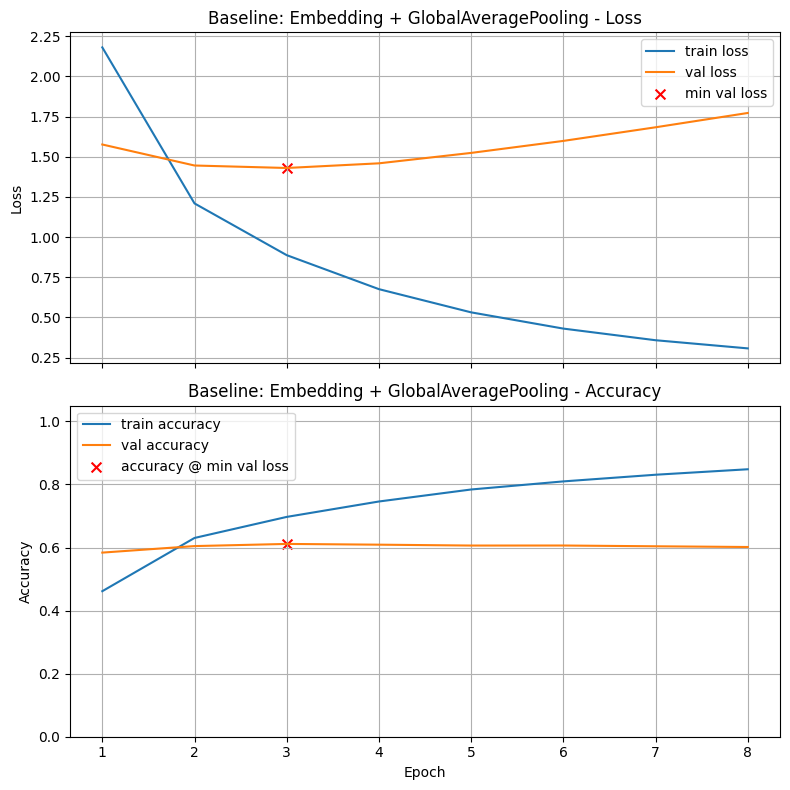

Final Training Loss:            0.3076
Final Training  accuracy:    0.8482
Final Validation Loss:          1.7722
Final Validation  accuracy:  0.6017
Min Validation Loss:            1.4299 (Epoch 3)
Accuracy @ Min Val Loss:      0.6114

Test metrics:
  loss: 1.4069
  accuracy: 0.6131

Execution Time: 0m 22s
Peak Memory Usage: 3412.36 MB


In [43]:
# Problem 2.2 – Train baseline with early stopping using train_and_test helper

baseline_summary, baseline_history = train_and_test(
    baseline_model,
    X_train=X_tr_int,
    y_train=y_tr,
    X_val=X_va_int,
    y_val=y_va,
    X_test=X_te_int,
    y_test=y_te,
    # Training hyperparameters
    epochs=30,
    batch_size=256,
    loss="sparse_categorical_crossentropy",   # equivalent to categorical_crossentropy with one-hot labels
    metrics=("accuracy",),
    learning_rate=1e-3,
    clipnorm=None,
    validation_split=0.0,         # we already have (X_val, y_val)
    random_state=42,
    title="Baseline: Embedding + GlobalAveragePooling",
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    use_reduce_lr=True,           # optional: uses ReduceLROnPlateau on val_loss
    class_weight=class_weights,   # from Problem 1;
    verbose=1,
    metric_for_curves="accuracy",
    results_dict=results,
    return_history=True,
)

In [44]:
print("\nBaseline summary dict:")
for k, v in baseline_summary.items():
    print(f"{k}: {v}")


Baseline summary dict:
title: Baseline: Embedding + GlobalAveragePooling
best_epoch_by_val_loss: 3
min_val_loss: 1.4299416542053223
accuracy_at_min_val_loss: 0.611398458480835
made_internal_val: False
test_metrics: {'loss': 1.4069441556930542, 'accuracy': 0.6131057143211365}
train_time_sec: 22.085371494293213
peak_memory_mb: 3412.359375


In [45]:
# Problem 2.3 – Extract key baseline performance numbers

best_epoch = baseline_summary["best_epoch_by_val_loss"]
val_acc_at_min_loss = baseline_summary.get("accuracy_at_min_val_loss", np.nan)
min_val_loss = baseline_summary["min_val_loss"]
train_time_sec = baseline_summary["train_time_sec"]

print(f"Best epoch (by min val_loss):        {best_epoch}")
print(f"Min validation loss:                 {min_val_loss:.4f}")
print(f"Validation accuracy @ min val_loss:  {val_acc_at_min_loss:.4f}")
print(f"Total training time:                 {train_time_sec/60:.2f} minutes")

Best epoch (by min val_loss):        3
Min validation loss:                 1.4299
Validation accuracy @ min val_loss:  0.6114
Total training time:                 0.37 minutes


In [46]:
# Problem 2.4 – Test metrics + macro-F1 + classification report

from sklearn.metrics import accuracy_score, f1_score, classification_report

test_metrics = baseline_summary["test_metrics"]
test_acc_keras = test_metrics.get("accuracy", np.nan)
test_loss_keras = test_metrics.get("loss", np.nan)

print(f"Keras test loss:      {test_loss_keras:.4f}")
print(f"Keras test accuracy:  {test_acc_keras:.4f}")

# Compute macro-F1 and a more detailed view
y_te_proba = baseline_model.predict(X_te_int, batch_size=256)
y_te_pred = np.argmax(y_te_proba, axis=1)

test_acc = accuracy_score(y_te, y_te_pred)
test_f1_macro = f1_score(y_te, y_te_pred, average="macro")

print(f"\nTest accuracy (sklearn):  {test_acc:.4f}")
print(f"Test macro-F1:            {test_f1_macro:.4f}\n")

print("Classification report (test set):")
print(classification_report(y_te, y_te_pred, target_names=label_names))


Keras test loss:      1.4069
Keras test accuracy:  0.6131
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Test accuracy (sklearn):  0.6131
Test macro-F1:            0.5485

Classification report (test set):
                precision    recall  f1-score   support

          ARTS       0.47      0.56      0.51       385
  BLACK VOICES       0.43      0.54      0.48       451
      BUSINESS       0.48      0.44      0.46       589
       COLLEGE       0.26      0.57      0.36       113
        COMEDY       0.44      0.48      0.46       500
         CRIME       0.44      0.64      0.52       339
       DIVORCE       0.66      0.81      0.73       343
     EDUCATION       0.22      0.54      0.31        99
 ENTERTAINMENT       0.73      0.54      0.62      1713
   ENVIRONMENT       0.42      0.58      0.49       392
         FIFTY       0.81      0.58      0.68      2910
  FOOD & DRINK       0.76      0.77      0.76       830
     GOOD NEWS       0.35      0.41      0.38       405
 HOME & LIVING  

In [47]:
from sklearn.metrics import f1_score
import numpy as np

def eval_f1(model, X, y, label_names=None, title=""):
    """
    Print F1 for each category + macro F1 + weighted F1.
    Assumes labels are encoded as 0..num_classes-1 in y.
    """
    # Predict class IDs
    y_pred_probs = model.predict(X, batch_size=256)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Per-class F1 (one value per label id)
    per_class_f1 = f1_score(y, y_pred, average=None)  # shape: (num_classes,)

    # Macro / weighted F1
    macro = f1_score(y, y_pred, average="macro")
    weighted = f1_score(y, y_pred, average="weighted")

    print(f"\n{title} – F1 scores")

    # Print per-category F1
    num_classes = len(per_class_f1)
    if label_names is None:
        label_names = [f"class_{i}" for i in range(num_classes)]

    print("\nPer-class F1:")
    for i in range(num_classes):
        print(f"  {i:2d}  {label_names[i]:30s}  F1 = {per_class_f1[i]:.4f}")

    # Print aggregated metrics
    print("\nAggregated F1:")
    print(f"  Macro F1:    {macro:.4f}")
    print(f"  Weighted F1: {weighted:.4f}")

    return per_class_f1, macro, weighted

### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**

The baseline model is a straightforward embedding-based classifier designed to establish a reference performance level for the HuffPost dataset. Its structure is as follows:

1. keras.layers.Embedding: This is the first layer, which converts integer-encoded input sequences (our vectorized text) into dense vectors of a fixed size (EMBED_DIM = 128).

    - Justification: Text data, consisting of words represented by integers, needs to be transformed into a format that neural networks can process meaningfully. An embedding layer learns a distributed representation for each word, where words with similar meanings are mapped to similar vector spaces. The mask_zero=True parameter ensures that padding tokens (zeros) do not contribute to the learning process.

2. keras.layers.GlobalAveragePooling1D: This layer takes the output of the embedding layer (a sequence of word vectors) and computes the average of these vectors across the time dimension for each sample.

    - Justification: For a classification task, we need a single, fixed-size representation of the entire input text. Global Average Pooling is an effective and computationally efficient way to condense the sequence of word embeddings into a single feature vector, summarizing the overall content of the text. It also helps to generalize better compared to simply flattening the embeddings.

3. keras.layers.Dense(128, activation="relu"): A fully connected (dense) hidden layer with 128 neurons, using the Rectified Linear Unit (ReLU) activation function.

    - Justification: This layer introduces non-linearity and allows the model to learn more complex patterns and relationships from the summarized text features. ReLU is a popular choice due to its computational efficiency and its ability to help mitigate vanishing gradient problems.

4. keras.layers.Dropout(0.3): A dropout layer applied after the hidden dense layer, with a dropout rate of 0.3.

    - Justification: This is a regularization technique. During training, it randomly sets 30% of the input units to zero, which helps prevent overfitting by forcing the network to be less reliant on any single neuron and encouraging it to learn more robust and generalized features.

5. keras.layers.Dense(num_classes, activation="softmax"): The output layer, which has a number of neurons equal to the total number of distinct categories (num_classes), and uses a softmax activation function.

    - Justification: For multi-class classification, this layer produces a probability distribution over all possible categories, indicating the likelihood that the input text belongs to each class. The softmax function ensures that these probabilities sum to 1.

This architecture is well-suited as a baseline for text classification because it combines the essential components for processing text (embeddings), summarizing it (pooling), and making a classification decision (dense layers with softmax), while remaining relatively simple and computationally inexpensive to train. It serves as a solid foundation to benchmark against more complex models.



2. **Training Behavior:**   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**

Analyzing the training and validation curves for the baseline model reveals the following key trends:

- Overfitting: The most prominent trend is the clear indication of overfitting. While the training loss consistently decreased and training accuracy steadily increased throughout the epochs, the validation loss reached its minimum at Epoch 4 (1.4757) and then began to increase. Similarly, validation accuracy peaked at Epoch 4 (0.6023) and subsequently started to decline.

- Divergence: A growing gap was observed between the training and validation metrics. By the time training was stopped, the training accuracy was significantly higher (0.7473) compared to the validation accuracy at its best (0.6023). This divergence further confirms that the model was learning the training data too well, to the detriment of its generalization performance on unseen validation data.

- Early Stopping Effectiveness: The early stopping mechanism was effective in preventing further overfitting. It halted training at Epoch 9 after detecting no significant improvement in validation loss for 5 consecutive epochs (patience=5) and restored the model weights from Epoch 4, which was the epoch with the minimum validation loss.



  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**

Validation Metrics (at epoch of minimum validation loss - Epoch 4):

- Minimum Validation Loss: 1.4757
- Validation Accuracy @ Min Val Loss: 0.6023

Test Metrics:

- Test Loss: 1.4949
- Test Accuracy (sklearn): 0.5973
- Test Macro-F1 Score: 0.4380

What this performance tells about dataset difficulty:

1. Challenging Multi-Class Classification: With 41 distinct categories, achieving an accuracy of around 60% on the test set for a baseline model indicates that this is a non-trivial multi-class classification problem. A random guess in 41 classes would yield an accuracy of roughly 2.4%, so 60% is a significant improvement, but still leaves considerable room for improvement.

2. Impact of Class Imbalance: The significant disparity between the Test Accuracy (0.5973) and the Test Macro-F1 Score (0.4380) strongly suggests that the dataset suffers from class imbalance, and that the model is struggling with the minority classes. Macro-F1 treats all classes equally, so a lower score implies poor performance on less frequent categories. The classification report confirms this, showing very low precision and recall for some of the least frequent classes (e.g., 'FIFTY' with an F1-score of 0.03, 'EDUCATION' with 0.29, 'LATINO VOICES' with 0.23).

3. Overfitting Tendency: As observed in the training behavior, the model shows an early tendency to overfit, with validation loss increasing after just a few epochs. This suggests that the dataset's complexity relative to the simple baseline model makes it easy for the model to memorize training patterns without generalizing well.

In summary, the dataset presents a moderate to high level of difficulty due to the large number of classes and significant class imbalance, which significantly impacts the model's ability to perform consistently across all categories.



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**

The baseline model, while serving its purpose as a starting point, has several clear limitations:

1. Overfitting: The most significant limitation is its rapid overfitting to the training data. The validation loss starts increasing after just 4 epochs, indicating that the model quickly memorizes training patterns without generalizing well to unseen data. This suggests either too much capacity for the given data/task, or insufficient regularization.

2. Limited Contextual Understanding: The GlobalAveragePooling1D layer averages the word embeddings, effectively losing information about word order and sequential dependencies within the text. This is a major drawback for natural language understanding tasks where word context is crucial.

3. Suboptimal Performance on Minority Classes: The low macro-F1 score (0.4380) compared to the overall accuracy (0.5973) highlights its struggle with less frequent categories, even with the application of class weights. This indicates that the model is biased towards majority classes and fails to learn robust features for minority ones.

To address these limitations, here are specific improvements I would try next:

- Depth (Recurrent Layers): Replace GlobalAveragePooling1D with recurrent neural network layers like Bidirectional LSTMs or GRUs. These layers are designed to process sequences and capture long-range dependencies, which would significantly improve the model's contextual understanding of the text. An architecture like Embedding -> Bidirectional LSTM/GRU -> GlobalMaxPooling1D/GlobalAveragePooling1D -> Dense -> Softmax would be a logical next step.

- Regularization: While dropout was applied, the overfitting suggests it might be insufficient. I would experiment with:

    - Increased Dropout Rates: Apply more aggressive dropout (e.g., 0.4 or 0.5) to both the embedding layer and subsequent dense layers.
    - Batch Normalization: Add BatchNormalization layers, especially before activation functions in dense layers, to stabilize training and allow for higher learning rates.
    - L1/L2 Regularization: Introduce L2 weight regularization to the Dense layers to penalize large weights and reduce model complexity.

- Pretraining (Transfer Learning): This is a major improvement direction. Instead of learning embeddings from scratch, I would integrate pre-trained word embeddings (like Word2Vec, GloVe, or FastText) or, for an even larger leap, use a pre-trained Transformer-based model (like DistilBERT, BERT) by fine-tuning it. This would leverage vast linguistic knowledge learned from enormous datasets, dramatically boosting the model's ability to understand language and potentially overcoming data scarcity for minority classes.



## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

In [48]:
num_classes

30

In [49]:
from tensorflow import keras
import tensorflow as tf

EMBED_DIM = 128  # keep same as baseline

hn = keras.initializers.HeNormal(seed=SEED)  # same pattern as HW08

inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")

# Embedding (same as baseline)
x = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    input_length=MAX_LEN,
    mask_zero=True,   # let the BiLSTM respect padding
)(inputs)

# BiLSTM core – no return_sequences, use final state as in HW08
x = keras.layers.Bidirectional(
    keras.layers.LSTM(
        32,
        dropout=0.2,           # input dropout (HW08-like)
        recurrent_dropout=0.2, # recurrent dropout
        return_sequences=False
    )
)(x)

# Small head, He-normal init, moderate dropout
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(
    32,
    activation="relu",
    kernel_initializer=hn
)(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

custom_model_v2 = keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="custom_bilstm",
)

custom_model_v2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "custom_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 33, 128)   │ 10,008,960 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 33)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     41,216 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30)        │        990 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,053,246 (38.35 MB)

 Trainable params: 10,053,246 (38.35 MB)

 Non-trainable params: 0 (0.00 B)


=== Custom v2 BiLSTM  ===

Epoch 1/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 100s 142ms/step - accuracy: 0.2163 - loss: 2.8895 - val_accuracy: 0.5405 - val_loss: 1.7663 - learning_rate: 0.0010
Epoch 2/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 142ms/step - accuracy: 0.5162 - loss: 1.6758 - val_accuracy: 0.5660 - val_loss: 1.6083 - learning_rate: 0.0010
Epoch 3/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.5891 - loss: 1.3052 - val_accuracy: 0.5700 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 4/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.6323 - loss: 1.0822 - val_accuracy: 0.5704 - val_loss: 1.6343 - learning_rate: 0.0010
Epoch 5/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.6676 - loss: 0.9263 - val_accuracy: 0.5719 - val_loss: 1.6772 - learning_rate: 0.0010
Epoch 6/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.6917 - loss: 0.8113 - val_accuracy: 0.5689 - val_loss: 1.7648 - learning_rate: 0.0010
Epoch 7/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 8

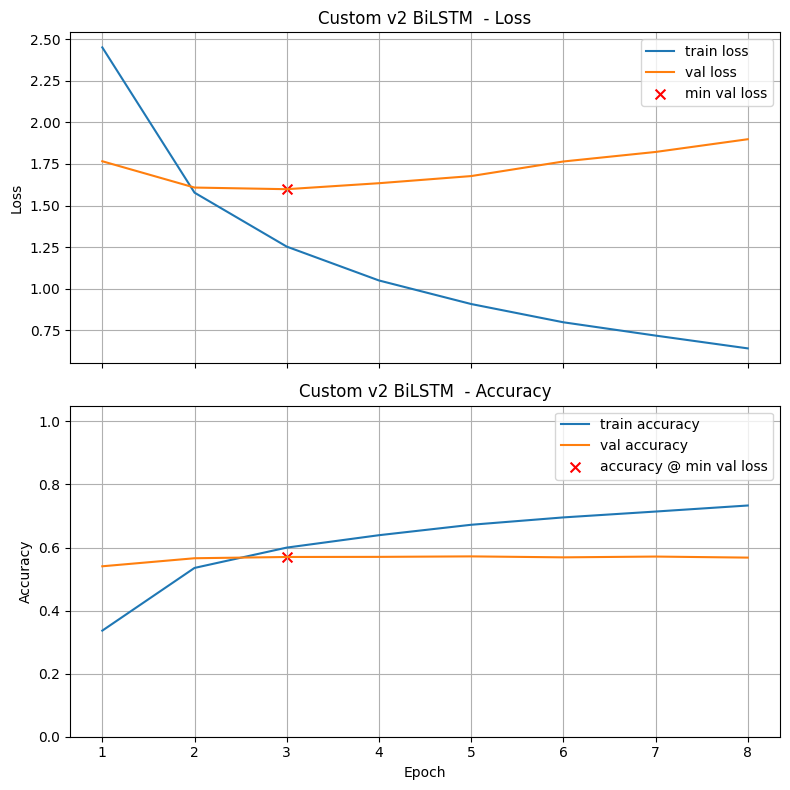

Final Training Loss:            0.6420
Final Training  accuracy:    0.7332
Final Validation Loss:          1.8985
Final Validation  accuracy:  0.5680
Min Validation Loss:            1.5984 (Epoch 3)
Accuracy @ Min Val Loss:      0.5700

Test metrics:
  loss: 1.5817
  accuracy: 0.5747

Execution Time: 11m 53s
Peak Memory Usage: 3643.93 MB


In [50]:
# Ensure inputs match labels; re-vectorize from raw text if needed
def ensure_vectorized_inputs(X_int, X_raw, y, name):
    X_arr = X_int
    if getattr(X_arr, "shape", None) and X_arr.shape[0] != len(y):
        print(f"{name} mismatch: {getattr(X_arr,'shape',None)} vs {len(y)} -> re-vectorizing from raw texts")
        X_arr = text_vec(np.asarray(list(X_raw)).astype("U"))
        print(f"Re-vectorized {name} shape: {X_arr.shape}")
    return X_arr

X_tr_int = ensure_vectorized_inputs(X_tr_int, X_tr, y_tr, "X_tr")
X_va_int = ensure_vectorized_inputs(X_va_int, X_va, y_va, "X_va")
X_te_int = ensure_vectorized_inputs(X_te_int, X_te, y_te, "X_te")

# Convert to concrete tf tensors for training
X_tr_tf = tf.convert_to_tensor(X_tr_int)
X_va_tf = tf.convert_to_tensor(X_va_int)
X_te_tf = tf.convert_to_tensor(X_te_int)

assert X_tr_tf.shape[0] == len(y_tr), f"X_tr {X_tr_tf.shape} vs y_tr {len(y_tr)}"
assert X_va_tf.shape[0] == len(y_va), f"X_va {X_va_tf.shape} vs y_va {len(y_va)}"
assert X_te_tf.shape[0] == len(y_te), f"X_te {X_te_tf.shape} vs y_te {len(y_te)}"

# Train using the fixed tensors
custom_summary_v2, custom_history_v2 = train_and_test(
    custom_model_v2,
    X_train=X_tr_tf,
    y_train=y_tr,
    X_val=X_va_tf,
    y_val=y_va,
    X_test=X_te_tf,
    y_test=y_te,
    epochs=30,
    batch_size=256,
    loss="sparse_categorical_crossentropy",
    metrics=("accuracy",),
    learning_rate=1e-3,       # slightly higher; Adam handles this well
    clipnorm=1.0,             # still good practice with LSTMs
    random_state=42,
    title="Custom v2 BiLSTM ",
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    use_reduce_lr=True,
    class_weight=class_weights,   # keep if you used it for baseline
    verbose=1,
    metric_for_curves="accuracy",
    results_dict=results,
    return_history=True,
)



=== Custom v2 BiLSTM ===

Epoch 1/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 96s 142ms/step - accuracy: 0.6414 - loss: 1.0767 - val_accuracy: 0.5724 - val_loss: 1.6289 - learning_rate: 0.0010
Epoch 2/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.6656 - loss: 0.9547 - val_accuracy: 0.5687 - val_loss: 1.6781 - learning_rate: 0.0010
Epoch 3/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 142ms/step - accuracy: 0.6884 - loss: 0.8315 - val_accuracy: 0.5730 - val_loss: 1.7319 - learning_rate: 0.0010
Epoch 4/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - accuracy: 0.7104 - loss: 0.7445 - val_accuracy: 0.5708 - val_loss: 1.8033 - learning_rate: 0.0010
Epoch 5/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 89s 142ms/step - accuracy: 0.7273 - loss: 0.6673 - val_accuracy: 0.5705 - val_loss: 1.8703 - learning_rate: 0.0010
Epoch 6/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7451 - loss: 0.6058
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
623/623 ━━━━━━━━━━━━━━━━━━━━ 89s 1

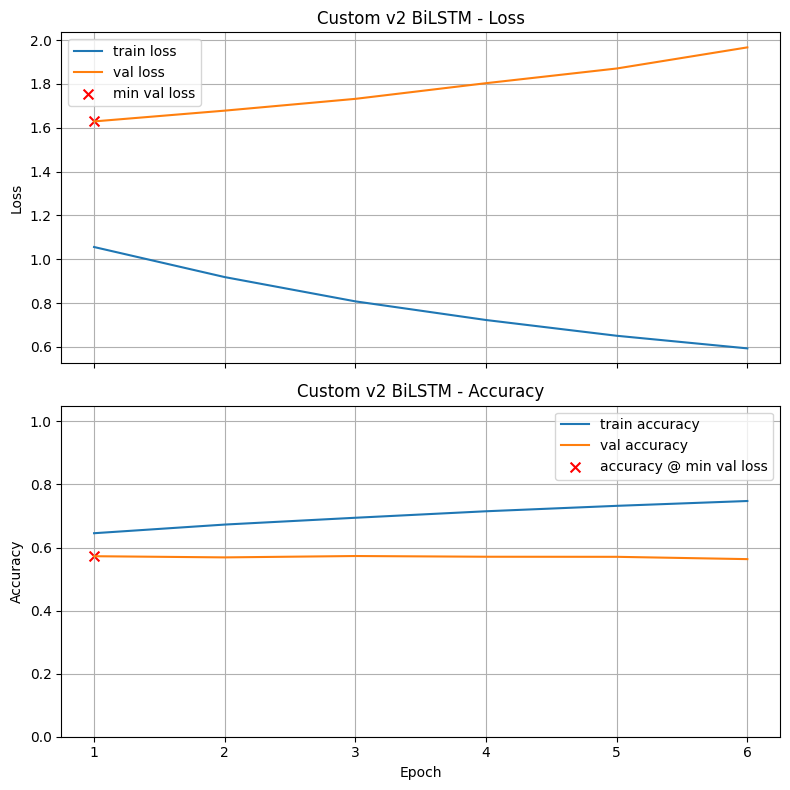

Final Training Loss:            0.5936
Final Training  accuracy:    0.7475
Final Validation Loss:          1.9666
Final Validation  accuracy:  0.5632
Min Validation Loss:            1.6289 (Epoch 1)
Accuracy @ Min Val Loss:      0.5724

Test metrics:
  loss: 1.6100
  accuracy: 0.5770

Execution Time: 8m 57s
Peak Memory Usage: 3725.11 MB

Custom v2 model summary dict:
title: Custom v2 BiLSTM
best_epoch_by_val_loss: 1
min_val_loss: 1.628900170326233
accuracy_at_min_val_loss: 0.572432816028595
made_internal_val: False
test_metrics: {'loss': 1.6100226640701294, 'accuracy': 0.5770022869110107}
train_time_sec: 537.5913763046265
peak_memory_mb: 3725.109375


In [51]:
custom_summary_v2, custom_history_v2 = train_and_test(
    custom_model_v2,
    X_train=X_tr_int,
    y_train=y_tr,
    X_val=X_va_int,
    y_val=y_va,
    X_test=X_te_int,
    y_test=y_te,
    epochs=30,
    batch_size=256,
    loss="sparse_categorical_crossentropy",
    metrics=("accuracy",),
    learning_rate=1e-3,       # slightly higher; Adam handles this well
    clipnorm=1.0,             # still good practice with LSTMs
    random_state=42,
    title="Custom v2 BiLSTM",
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    use_reduce_lr=True,
    class_weight=class_weights,   # keep if you used it for baseline
    verbose=1,
    metric_for_curves="accuracy",
    results_dict=results,
    return_history=True,
)

print("\nCustom v2 model summary dict:")
for k, v in custom_summary_v2.items():
    print(f"{k}: {v}")

In [52]:
# Problem 3 – Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool

from tensorflow import keras
import tensorflow as tf

tf.random.set_seed(SEED)

EMBED_DIM = 128  # keep comparable to baseline

inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")

# Embedding + SpatialDropout1D for better regularization in sequence models
x = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    input_length=MAX_LEN,
    mask_zero=True,
)(inputs)

x = keras.layers.SpatialDropout1D(0.2)(x)

# BiLSTM core – small, with dropout and recurrent dropout
x = keras.layers.Bidirectional(
    keras.layers.LSTM(
        32,
        return_sequences=True,    # we want the full sequence for pooling
        dropout=0.2,
        recurrent_dropout=0.2,
    )
)(x)

# Combine GlobalMaxPooling and GlobalAveragePooling
x_max = keras.layers.GlobalMaxPooling1D()(x)
x_avg = keras.layers.GlobalAveragePooling1D()(x)

x = keras.layers.Concatenate()([x_max, x_avg])

# Compact dense head with strong dropout
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

custom_model_v3 = keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="custom_bilstm_spatialdrop_maxavg",
)

custom_model_v3.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "custom_bilstm_spatialdrop_maxavg"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 33, 128)   │ 10,008,960 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 33, 128)   │          0 │ embedding_2[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 33)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 33, 64)    │     41,216 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bidirectional_1[… │
│ (GlobalAveragePool… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30)        │      1,950 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,060,382 (38.38 MB)

 Trainable params: 10,060,382 (38.38 MB)

 Non-trainable params: 0 (0.00 B)


=== Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool ===

Epoch 1/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 117s 174ms/step - accuracy: 0.1196 - loss: 3.1581 - val_accuracy: 0.4505 - val_loss: 2.1215 - learning_rate: 5.0000e-04
Epoch 2/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.3999 - loss: 2.0820 - val_accuracy: 0.5353 - val_loss: 1.7670 - learning_rate: 5.0000e-04
Epoch 3/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.5102 - loss: 1.6473 - val_accuracy: 0.5527 - val_loss: 1.6724 - learning_rate: 5.0000e-04
Epoch 4/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 106s 170ms/step - accuracy: 0.5618 - loss: 1.4145 - val_accuracy: 0.5598 - val_loss: 1.6359 - learning_rate: 5.0000e-04
Epoch 5/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 107s 172ms/step - accuracy: 0.5972 - loss: 1.2547 - val_accuracy: 0.5676 - val_loss: 1.6348 - learning_rate: 5.0000e-04
Epoch 6/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 109s 174ms/step - accuracy: 0.6247 - loss: 1.1302 - val_accuracy: 0.5693 - val_loss: 1.6508 - learni

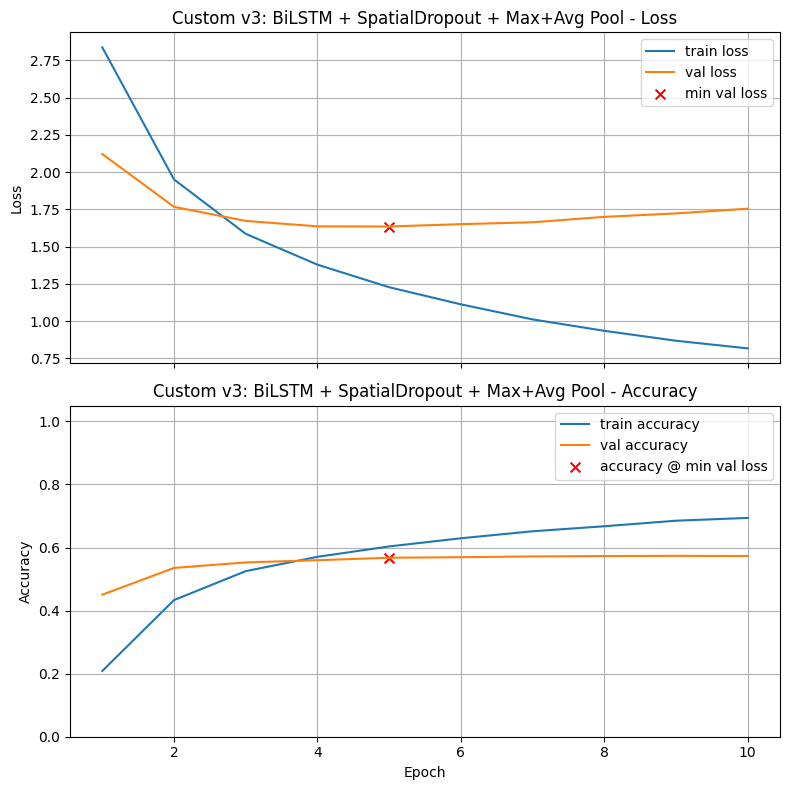

Final Training Loss:            0.8165
Final Training  accuracy:    0.6939
Final Validation Loss:          1.7545
Final Validation  accuracy:  0.5730
Min Validation Loss:            1.6348 (Epoch 5)
Accuracy @ Min Val Loss:      0.5676

Test metrics:
  loss: 1.6224
  accuracy: 0.5693

Execution Time: 17m 53s
Peak Memory Usage: 3781.98 MB

Custom v3 model summary dict:
title: Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool
best_epoch_by_val_loss: 5
min_val_loss: 1.6348170042037964
accuracy_at_min_val_loss: 0.5675621628761292
made_internal_val: False
test_metrics: {'loss': 1.6224101781845093, 'accuracy': 0.5692694187164307}
train_time_sec: 1073.4833145141602
peak_memory_mb: 3781.984375


In [53]:
# Problem 3 – Train Custom v3 with the same conditions as baseline

custom_summary_v3, custom_history_v3 = train_and_test(
    custom_model_v3,
    X_train=X_tr_int,
    y_train=y_tr,
    X_val=X_va_int,
    y_val=y_va,
    X_test=X_te_int,
    y_test=y_te,
    epochs=30,
    batch_size=256,
    loss="sparse_categorical_crossentropy",
    metrics=("accuracy",),
    learning_rate=5e-4,
    clipnorm=1.0,
    random_state=42,
    title="Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool",
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    use_reduce_lr=True,
    class_weight=class_weights,   # if used for baseline
    verbose=1,
    metric_for_curves="accuracy",
    results_dict=results,
    return_history=True,
)

print("\nCustom v3 model summary dict:")
for k, v in custom_summary_v3.items():
    print(f"{k}: {v}")


In [54]:
# Problem 3 – AttentionPooling1D
import tensorflow as tf
from tensorflow import keras

class AttentionPooling1D(keras.layers.Layer):
    """
    Simple learned attention pooling over time.
    Expects inputs of shape (batch, time, features).
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.score = keras.layers.Dense(1, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        # inputs: (batch, time, features)
        scores = self.score(inputs)            # (batch, time, 1)
        scores = tf.squeeze(scores, axis=-1)   # (batch, time)

        if mask is not None:
            # mask: (batch, time) -> set padded positions to -inf
            mask = tf.cast(mask, tf.float32)
            scores += (1.0 - mask) * -1e9

        weights = tf.nn.softmax(scores, axis=-1)  # (batch, time)
        weights = tf.expand_dims(weights, axis=-1)  # (batch, time, 1)

        weighted = inputs * weights               # (batch, time, features)
        return tf.reduce_sum(weighted, axis=1)    # (batch, features)

    def compute_mask(self, inputs, mask=None):
        # We collapse time dimension; no mask passed on
        return None


In [55]:
# Problem 3 – Custom Model 2: Embedding + SpatialDropout + BiLSTM + AttentionPooling

EMBED_DIM = 128  # stay consistent with baseline
hn = keras.initializers.HeNormal(seed=SEED)

inputs = keras.Input(shape=(MAX_LEN,), dtype="int32")

x = keras.layers.Embedding(
    input_dim=new_vocab_size,
    output_dim=EMBED_DIM,
    input_length=MAX_LEN,
    mask_zero=True,       # needed so attention/LSTM can ignore padding
)(inputs)

# SpatialDropout1D is usually better than plain Dropout for sequence models
x = keras.layers.SpatialDropout1D(0.2)(x)

x = keras.layers.Bidirectional(
    keras.layers.LSTM(
        128,
        dropout=0.3,
        return_sequences=True,   # we want the full sequence for attention
    )
)(x)

# Attention over timesteps (similar to Week08 Model 07)
x = AttentionPooling1D()(x)

x = keras.layers.Dense(
    64,
    activation="relu",
    kernel_initializer=hn,
)(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

custom_model_2 = keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="custom_bilstm_attention_4",
)

custom_model_2.summary()


Model: "custom_bilstm_attention_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 33, 128)   │ 10,008,960 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 33, 128)   │          0 │ embedding_3[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 33)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 33, 256)   │    263,168 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pooling1d │ (None, 256)       │        256 │ bidirectional_2[… │
│ (AttentionPooling1… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     16,448 │ attention_poolin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30)        │      1,950 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,290,782 (39.26 MB)

 Trainable params: 10,290,782 (39.26 MB)

 Non-trainable params: 0 (0.00 B)


=== Custom 2: BiLSTM + Attention (Week08 Model 07 LR style) ===

Epoch 1/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.0753 - loss: 3.3575 - val_accuracy: 0.2849 - val_loss: 2.7735 - learning_rate: 1.0000e-04
Epoch 2/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.2598 - loss: 2.7944 - val_accuracy: 0.3573 - val_loss: 2.3874 - learning_rate: 1.0000e-04
Epoch 3/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3088 - loss: 2.4538 - val_accuracy: 0.4078 - val_loss: 2.1957 - learning_rate: 1.0000e-04
Epoch 4/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3542 - loss: 2.2035 - val_accuracy: 0.4364 - val_loss: 2.0690 - learning_rate: 1.0000e-04
Epoch 5/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3954 - loss: 2.0210 - val_accuracy: 0.4622 - val_loss: 1.9809 - learning_rate: 1.0000e-04
Epoch 6/30
623/623 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4336 - loss: 1.8779 - val_accuracy: 0.4791 - val_loss: 1.9235 - learning_rate: 1.

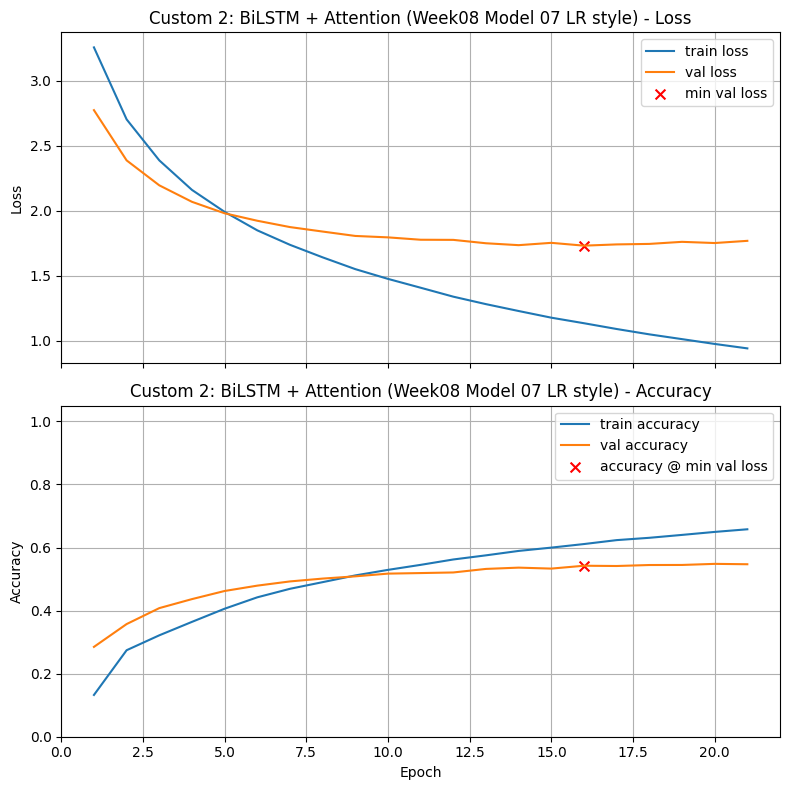

Final Training Loss:            0.9426
Final Training  accuracy:    0.6578
Final Validation Loss:          1.7691
Final Validation  accuracy:  0.5470
Min Validation Loss:            1.7321 (Epoch 16)
Accuracy @ Min Val Loss:      0.5423

Test metrics:
  loss: 1.7226
  accuracy: 0.5446

Execution Time: 2m 57s
Peak Memory Usage: 3855.02 MB

Custom 2 model summary dict:
title: Custom 2: BiLSTM + Attention (Week08 Model 07 LR style)
best_epoch_by_val_loss: 16
min_val_loss: 1.7320631742477417
accuracy_at_min_val_loss: 0.5422545671463013
made_internal_val: False
test_metrics: {'loss': 1.7226115465164185, 'accuracy': 0.544564425945282}
train_time_sec: 177.88028192520142
peak_memory_mb: 3855.01953125


In [56]:
custom_summary_2, custom_history_2 = train_and_test(
    custom_model_2,
    X_train=X_tr_int,
    y_train=y_tr,
    X_val=X_va_int,
    y_val=y_va,
    X_test=X_te_int,
    y_test=y_te,
    epochs=30,
    batch_size=256,
    loss="sparse_categorical_crossentropy",
    metrics=("accuracy",),
    learning_rate=1e-4,       # smaller LR (Week08 Model 07 LR style)
    clipnorm=1.0,
    random_state=42,
    title="Custom 2: BiLSTM + Attention (Week08 Model 07 LR style)",
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    use_reduce_lr=True,
    class_weight=class_weights,
    verbose=1,
    metric_for_curves="accuracy",
    results_dict=results,
    return_history=True,
)

print("\nCustom 2 model summary dict:")
for k, v in custom_summary_2.items():
    print(f"{k}: {v}")


In [57]:
print("\n--- Evaluating Custom v2 BiLSTM ---")
per_class_f1_custom_v2, custom_v2_macro_f1, custom_v2_weighted_f1 = eval_f1(
    custom_model_v2, X_te_int, y_te, label_names=label_names, title="Custom v2 BiLSTM"
)

print("\n--- Evaluating Custom v3 BiLSTM + SpatialDropout + Max+Avg Pool ---")
per_class_f1_custom_v3, custom_v3_macro_f1, custom_v3_weighted_f1 = eval_f1(
    custom_model_v3, X_te_int, y_te, label_names=label_names, title="Custom v3 BiLSTM + SpatialDropout + Max+Avg Pool"
)

print("\n--- Evaluating Custom 2: BiLSTM + Attention (Week08 Model 07 LR style) ---")
per_class_f1_custom_2, custom_2_macro_f1, custom_2_weighted_f1 = eval_f1(
    custom_model_2, X_te_int, y_te, label_names=label_names, title="Custom 2: BiLSTM + Attention (Week08 Model 07 LR style)"
)


--- Evaluating Custom v2 BiLSTM ---
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step

Custom v2 BiLSTM – F1 scores

Per-class F1:
   0  ARTS                            F1 = 0.4655
   1  BLACK VOICES                    F1 = 0.4505
   2  BUSINESS                        F1 = 0.4040
   3  COLLEGE                         F1 = 0.3296
   4  COMEDY                          F1 = 0.4338
   5  CRIME                           F1 = 0.4680
   6  DIVORCE                         F1 = 0.7158
   7  EDUCATION                       F1 = 0.2939
   8  ENTERTAINMENT                   F1 = 0.5635
   9  ENVIRONMENT                     F1 = 0.4568
  10  FIFTY                           F1 = 0.6223
  11  FOOD & DRINK                    F1 = 0.7531
  12  GOOD NEWS                       F1 = 0.2930
  13  HOME & LIVING                   F1 = 0.7030
  14  MEDIA                           F1 = 0.4145
  15  MONEY                           F1 = 0.3750
  16  PARENTING                       F1 = 0.6113
  17  POLITICS              

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step

Custom v3 BiLSTM + SpatialDropout + Max+Avg Pool – F1 scores

Per-class F1:
   0  ARTS                            F1 = 0.4691
   1  BLACK VOICES                    F1 = 0.4391
   2  BUSINESS                        F1 = 0.3791
   3  COLLEGE                         F1 = 0.3508
   4  COMEDY                          F1 = 0.4447
   5  CRIME                           F1 = 0.4739
   6  DIVORCE                         F1 = 0.6941
   7  EDUCATION                       F1 = 0.3324
   8  ENTERTAINMENT                   F1 = 0.5384
   9  ENVIRONMENT                     F1 = 0.4459
  10  FIFTY                           F1 = 0.6050
  11  FOOD & DRINK                    F1 = 0.7265
  12  GOOD NEWS                       F1 = 0.3208
  13  HOME & LIVING                   F1 = 0.6728
  14  MEDIA                           F1 = 0.4538
  15  MONEY                           F1 = 0.4261
  16  PARENTING                       F1 = 0.6058
  17  POLITICS                   

In [58]:
print_results(results)

Sorting results by: accuracy_at_min_val_loss

Baseline: Embedding + GlobalAveragePooling  0.6114  (best epoch=3)
Custom v2 BiLSTM                          0.5724  (best epoch=1)
Custom v2 BiLSTM                          0.5700  (best epoch=3)
Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool  0.5676  (best epoch=5)
Custom 2: BiLSTM + Attention (Week08 Model 07 LR style)  0.5423  (best epoch=16)


### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**



3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


In [60]:
# Experiment-specific Configuration

EPOCHS = 10         # Max epochs for each run
N_PARTIAL_LAYERS = 2  # How many top layers to unfreeze for partial training
EVAL_BATCH = 16     # Default batch size for evaluation

# Generate model_configs for various batch sizes and strategies
# This list defines the types of models and strategies to test, independent of subset_frac
ALL_MODEL_CONFIGS = []

for model_n in ["distil_bert_base_en_uncased", "bert_base_en_uncased", ]:
    for batch_s in [8, 16, 32]:
        freeze_lr = 1e-5
        partial_lr = 1e-5
        full_lr = 1e-5

        ALL_MODEL_CONFIGS.append({"name": model_n, "batch": batch_s, "lr": freeze_lr, "strategy": "freeze",  "unfreeze_layers": 0})
        ALL_MODEL_CONFIGS.append({"name": model_n, "batch": batch_s, "lr": partial_lr, "strategy": "partial", "unfreeze_layers": N_PARTIAL_LAYERS})
        ALL_MODEL_CONFIGS.append({"name": model_n, "batch": batch_s, "lr": full_lr, "strategy": "full",    "unfreeze_layers": None})


def set_fine_tune_mode(model, strategy="freeze", unfreeze_layers=0):
    """
    model: Keras TextClassifier model from kh.models.*
    strategy: one of "freeze", "partial", "full"
    unfreeze_layers: for 'partial' -> number of top encoder layers to unfreeze (e.g., 2)
    """
    # Access the backbone via the .backbone attribute for KerasNLP models not all models will have it but BERT and DistinBERT has it
    # This will help us use this for  different kind of model if it has backbone attribute else it will gracefully exit with Free = true

    backbone = model.backbone if hasattr(model, 'backbone') else None

    if strategy == "freeze":
        if backbone is not None:
            backbone.trainable = False
        else:
            model.trainable = False
        print("Strategy: FREEZE (backbone frozen).")
        return

    if strategy == "full":
        if backbone is not None:
            backbone.trainable = True
        model.trainable = True
        print("Strategy: FULL (all layers trainable).")
        return

    if strategy == "partial":
        if not backbone:
            model.trainable = True
            print("Partial fallback: could not find backbone; setting whole model trainable.")
            return

        backbone.trainable = False

        candidate_layers = []
        for l in backbone.layers:
            if 'encoder_block' in l.name or 'transformer' in l.name or 'layer_' in l.name:
                candidate_layers.append(l)

        if not candidate_layers:
            candidate_layers = backbone.layers

        candidate_layers = list(dict.fromkeys(candidate_layers))

        if unfreeze_layers is None or unfreeze_layers <= 0:
            backbone.trainable = True
            print("Partial requested but unfreeze_layers <= 0; making entire backbone trainable.")
            return

        n = min(unfreeze_layers, len(candidate_layers))
        layers_to_unfreeze = candidate_layers[-n:]

        for l in layers_to_unfreeze:
            l.trainable = True

        backbone.trainable = True
        print(f"Strategy: PARTIAL (unfroze last {n} layers of backbone).")
        return

    print("Unknown strategy; defaulting to freeze.")
    if backbone is not None:
        backbone.trainable = False
    else:
        model.trainable = False



def run_experiment_loop(
    current_subset_frac,
    model_configs_list=ALL_MODEL_CONFIGS,
    max_epochs=EPOCHS,
    n_partial_layers=N_PARTIAL_LAYERS,
    eval_batch_size=EVAL_BATCH,
    all_dataset=all_ds,
    num_classes_global=num_classes,
    label_names_global=label_names,
    class_weights_global=class_weights,
    use_reduce_lr = False,
    patience = 3
):
    local_results = {}
    local_subset_stats = []

    print(f"\n{'-'*100}")
    print(f"RUNNING EXPERIMENTS FOR DATASET SUBSET FRACTION: {current_subset_frac}")
    print(f"{'-'*100}\n")

    for cfg in model_configs_list:
        model_name = cfg["name"]
        BATCH = cfg["batch"]
        LR = cfg["lr"]
        strategy = cfg.get("strategy", "freeze")
        unfreeze_layers = cfg.get("unfreeze_layers", n_partial_layers) # Use n_partial_layers from func arg

        print("\n" + "-"*80)
        print(f"Running: model={model_name}  batch={BATCH}  lr={LR:.1e}  strategy={strategy}")
        print("-"*80 + "\n")

        # Dataset split logic

        ds_pool_current = all_dataset
        if 0.0 < current_subset_frac < 1.0:
            sub = all_dataset.train_test_split(
                train_size=current_subset_frac,
                seed=SEED,
                stratify_by_column="label"
            )
            ds_pool_current = sub["train"]
        print(f"Using subset of size {len(ds_pool_current)} (from total {len(all_dataset)}) for this run.")

        splits = ds_pool_current.train_test_split(test_size=0.20, seed=SEED, stratify_by_column="label")
        train_val_pool, test_ds = splits["train"], splits["test"]

        splits2 = train_val_pool.train_test_split(
            test_size=0.125, seed=SEED,
            stratify_by_column="label"
        )
        train_ds, val_ds = splits2["train"], splits2["test"]

        X_tr = np.array(train_ds["text"], dtype=object)
        y_tr = np.array(train_ds["label"], dtype="int32")

        X_va = np.array(val_ds["text"], dtype=object)
        y_va = np.array(val_ds["label"], dtype="int32")

        X_te = np.array(test_ds["text"], dtype=object)
        y_te = np.array(test_ds["label"], dtype="int32")

        # internal helper methid to count samples in splits
        def _counts_for_splits(ds_obj):
            arr = np.array(ds_obj["label"], dtype=int)
            return len(arr), np.bincount(arr, minlength=num_classes_global).tolist()

        print(f"Split sizes: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")
        print(f"Train counts: {_counts_for_splits(train_ds)[0]} samples")


        #  TRAIN EACH STRATEGY

        # Build preprocessor + model fresh every time to avoid state leakage
        if model_name == "distil_bert_base_en_uncased":
            preproc = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
                model_name, sequence_length=MAX_LEN
            )
            model = kh.models.DistilBertTextClassifier.from_preset(
                model_name,
                num_classes=num_classes_global,
                preprocessor=preproc,
                activation="softmax",
            )
        elif model_name == "bert_base_en_uncased":
            preproc = kh.models.BertTextClassifierPreprocessor.from_preset(
                model_name, sequence_length=MAX_LEN
            )
            model = kh.models.BertTextClassifier.from_preset(
                model_name,
                num_classes=num_classes_global,
                preprocessor=preproc,
                activation="softmax",
            )
        else:
            raise ValueError(f"Unknown model name: {model_name}")
        # model.summary()   # when in doubt print the model
        # Apply fine-tuning strategy (freeze/partial/full)
        set_fine_tune_mode(model, strategy=strategy, unfreeze_layers=unfreeze_layers)

        # Determine number of epochs for current strategy
        current_epochs = max_epochs # default
        if strategy == "partial":
            current_epochs = int(max_epochs * 1.5)
        elif strategy == "full":
            current_epochs = int(max_epochs * 2)

        optimizer = keras.optimizers.Adam(learning_rate=LR)
        #create params for reduce on plateau
        reduce_lr_params = dict(
            monitor="val_loss",
            factor=0.5,
            patience=2,      # < early stopping patience (e.g., 4)
            min_delta=1e-4,
            cooldown=0,
            min_lr=1e-8,
            verbose=1,
        )

        # Call the train and test method train_and_test helper function
        summary, _ = train_and_test(
          model,
          X_train=X_tr,
          y_train=y_tr,
          X_val=X_va,
          y_val=y_va,
          X_test=X_te,
          y_test=y_te,
          epochs=current_epochs, # Use the epochs setup
          batch_size=BATCH,      # Use BATCH from cfg
          optimizer=optimizer,
          loss="sparse_categorical_crossentropy",
          metrics=("accuracy",),
          learning_rate=LR,      # Passed to train_and_test, but optimizer will take precedence
          clipnorm=1.0,          # Gradient clipping often helps with regularization with Transformers due to better stabilization, avoid expolding gradient
          title=f"{model_name} | {strategy} |  batch={BATCH} | LR={LR:.1e} | Dataset-fraction={subset_frac}", # Initial title without time
          use_early_stopping=True,
          patience = patience,
          min_delta=1e-4,
          use_reduce_lr=use_reduce_lr, # while fin tuniing will do false to get sine tuned perfromance
          reduce_lr_params=reduce_lr_params,   # <<< pass params explicitly
          class_weight=class_weights if 'class_weights' in globals() else None, # Use computed class weights
          verbose=1,
          metric_for_curves="accuracy",
          results_dict=results,
          return_history=True, # We get summary and test metrics from train_and_test
        )

        # Retrieve elapsed time and memory and add it to the title in results dict
        elapsed_time_sec = summary.get('train_time_sec', np.nan)
        formatted_time = _format_hms(elapsed_time_sec) if not np.isnan(elapsed_time_sec) else "N/A"
        peak_memory_mb = summary.get('peak_memory_mb', np.nan)
        formatted_memory = f"{peak_memory_mb:.2f}MB" if not np.isnan(peak_memory_mb) else "N/A"

        # Update the title within the summary for better logging/display
        updated_title = f"{model_name} | {strategy} |  batch={BATCH} | LR={LR:.1e} | Dataset-fraction={current_subset_frac} | Time={formatted_time} | Mem={formatted_memory}"
        summary['title'] = updated_title

        # Also update the title in the local results dictionary
        local_results[updated_title] = summary
        print("\nSummary of run:")
        for k, v in summary.items():
            print(f"  {k}: {v}")

        test_acc = summary['test_metrics'].get('accuracy', np.nan) # Changed 'compile_metrics' to 'accuracy'
        test_f1_macro = f1_score(y_te, np.argmax(model.predict(X_te, batch_size=eval_batch_size, verbose=0), axis=1), average="macro")

        print(f"Test accuracy (from summary): {test_acc:.4f}")
        print(f"Test macro-F1 (recalculated): {test_f1_macro:.4f}\n")

        local_subset_stats.append({
            "model": model_name,
            "strategy": strategy,
            "batch": BATCH,
            "lr": LR,
            "val_acc_at_min_loss": summary.get('accuracy_at_min_val_loss', np.nan),
            "min_val_loss": summary.get('min_val_loss', np.nan),
            "test_loss": summary['test_metrics'].get('loss', np.nan),
            "test_acc": test_acc,
            "test_f1_macro": test_f1_macro,
            "elapsed_sec": elapsed_time_sec,
            "peak_memory_mb": peak_memory_mb,
            "dataset_fraction": current_subset_frac,
        })

    print(f"\n\n==== Experiment Loop for subset_frac={current_subset_frac} complete ====\n")
    return local_results, local_subset_stats


In [61]:
all_experiment_results = {}
all_subset_stats = []


----------------------------------------------------------------------------------------------------
RUNNING EXPERIMENTS FOR DATASET SUBSET FRACTION: 0.1
----------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=8  lr=1.0e-05  strategy=freeze
--------------------------------------------------------------------------------

Using subset of size 19914 (from total 199146) for this run.
Split sizes: Train=13939, Val=1992, Test=3983
Train counts: 13939 samples
Strategy: FREEZE (backbone frozen).

=== distil_bert_base_en_uncased | freeze |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 ===

Epoch 1/10
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.0590 - loss: 3.3635 - val_accuracy: 0.2942 - val_loss: 3.3037
Epoch 2/10
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2629 - loss: 3.2717 - val_accura

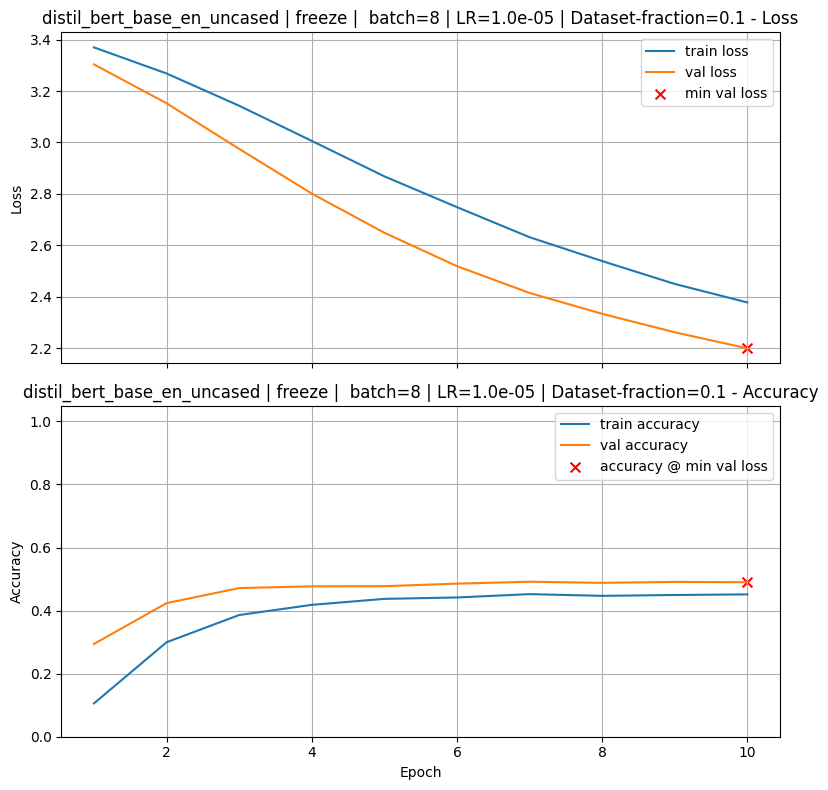

Final Training Loss:            2.3781
Final Training  accuracy:    0.4514
Final Validation Loss:          2.1994
Final Validation  accuracy:  0.4900
Min Validation Loss:            2.1994 (Epoch 10)
Accuracy @ Min Val Loss:      0.4900

Test metrics:
  loss: 2.2330
  accuracy: 0.4831

Execution Time: 2m 32s
Peak Memory Usage: 5075.91 MB

Summary of run:
  title: distil_bert_base_en_uncased | freeze |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=2m 32s | Mem=5075.91MB
  best_epoch_by_val_loss: 10
  min_val_loss: 2.19940447807312
  accuracy_at_min_val_loss: 0.48995983600616455
  made_internal_val: False
  test_metrics: {'loss': 2.2330098152160645, 'accuracy': 0.48305296897888184}
  train_time_sec: 152.6302900314331
  peak_memory_mb: 5075.9140625
Test accuracy (from summary): 0.4831
Test macro-F1 (recalculated): 0.3704


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=8  lr=1.0e-05  strategy=partial

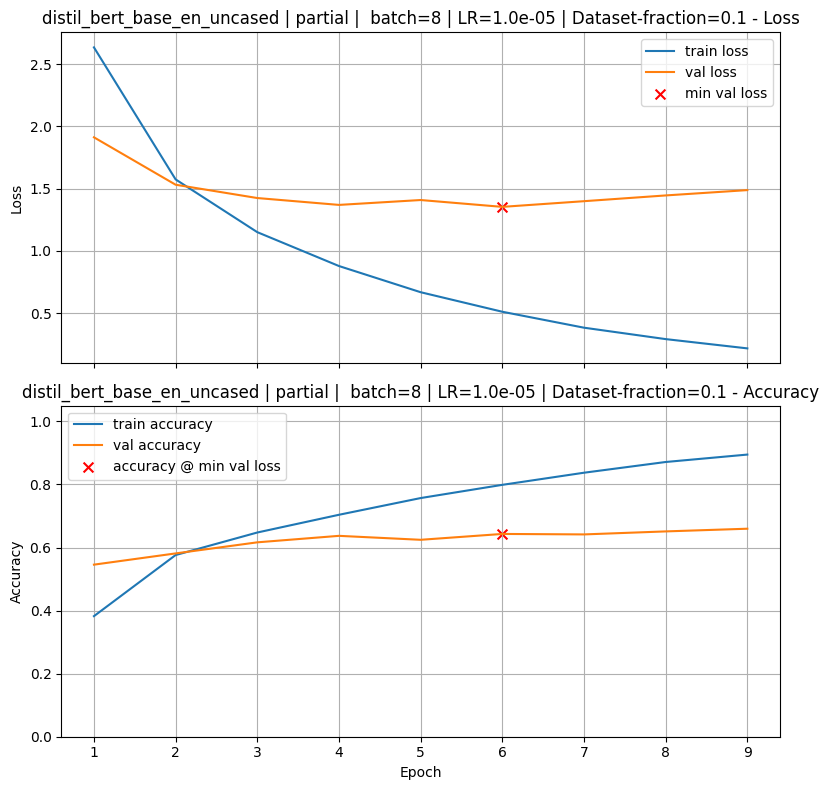

Final Training Loss:            0.2181
Final Training  accuracy:    0.8948
Final Validation Loss:          1.4888
Final Validation  accuracy:  0.6596
Min Validation Loss:            1.3542 (Epoch 6)
Accuracy @ Min Val Loss:      0.6431

Test metrics:
  loss: 1.4996
  accuracy: 0.6194

Execution Time: 5m 28s
Peak Memory Usage: 6344.32 MB

Summary of run:
  title: distil_bert_base_en_uncased | partial |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=5m 28s | Mem=6344.32MB
  best_epoch_by_val_loss: 6
  min_val_loss: 1.354239821434021
  accuracy_at_min_val_loss: 0.6430723071098328
  made_internal_val: False
  test_metrics: {'loss': 1.499595046043396, 'accuracy': 0.619382381439209}
  train_time_sec: 328.35805797576904
  peak_memory_mb: 6344.32421875
Test accuracy (from summary): 0.6194
Test macro-F1 (recalculated): 0.5475


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=8  lr=1.0e-05  strategy=full
----

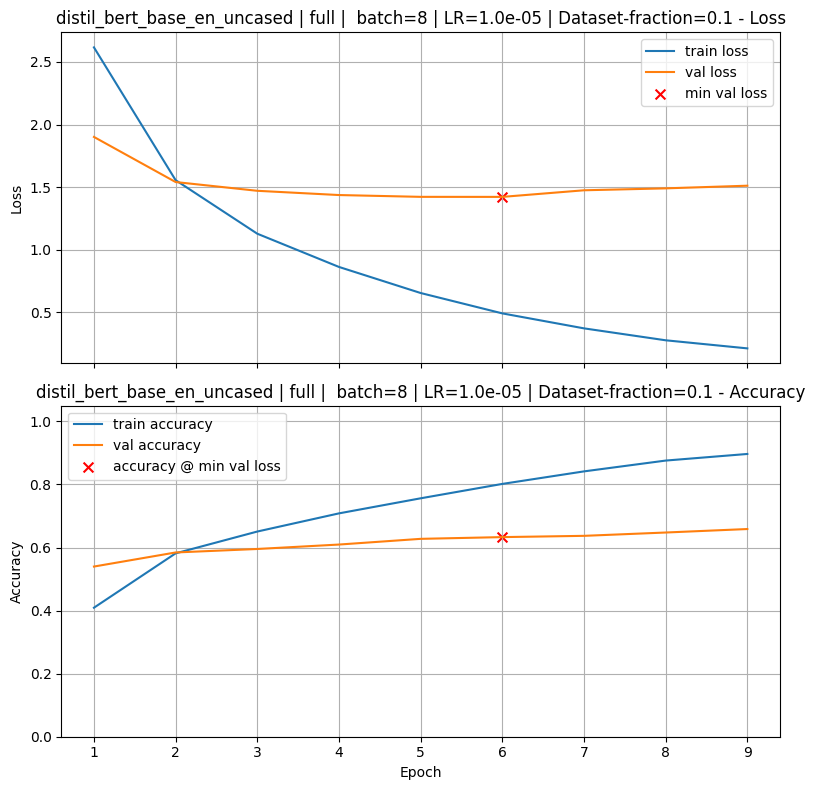

Final Training Loss:            0.2135
Final Training  accuracy:    0.8967
Final Validation Loss:          1.5121
Final Validation  accuracy:  0.6586
Min Validation Loss:            1.4228 (Epoch 6)
Accuracy @ Min Val Loss:      0.6330

Test metrics:
  loss: 1.5465
  accuracy: 0.6166

Execution Time: 5m 21s
Peak Memory Usage: 7197.75 MB

Summary of run:
  title: distil_bert_base_en_uncased | full |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=5m 21s | Mem=7197.75MB
  best_epoch_by_val_loss: 6
  min_val_loss: 1.4227975606918335
  accuracy_at_min_val_loss: 0.6330321431159973
  made_internal_val: False
  test_metrics: {'loss': 1.546486735343933, 'accuracy': 0.616620659828186}
  train_time_sec: 321.536908864975
  peak_memory_mb: 7197.75
Test accuracy (from summary): 0.6166
Test macro-F1 (recalculated): 0.5510


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=freeze
-----------

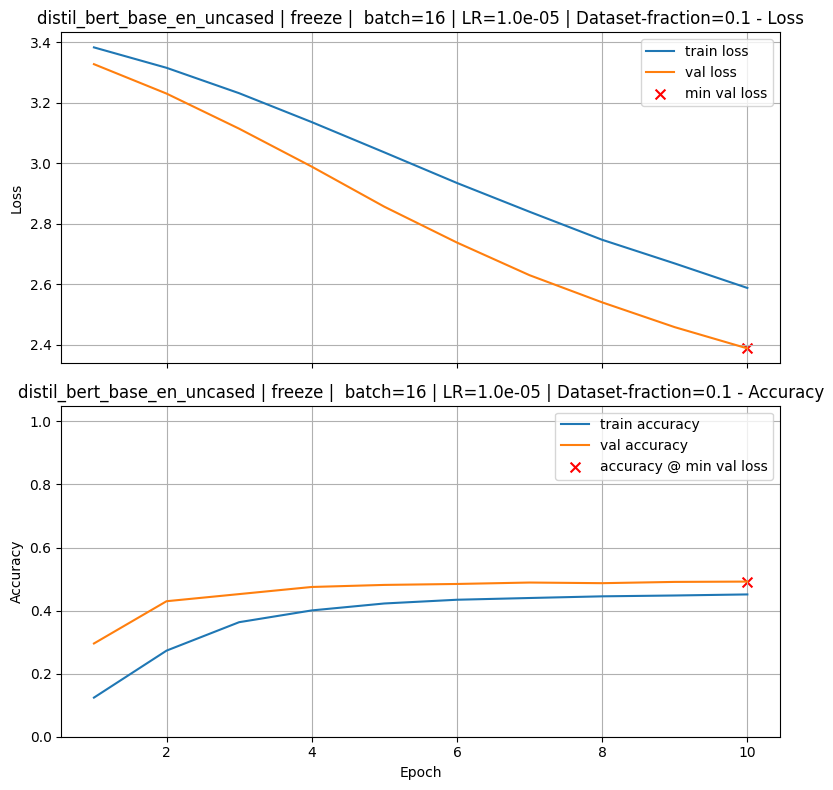

Final Training Loss:            2.5871
Final Training  accuracy:    0.4513
Final Validation Loss:          2.3872
Final Validation  accuracy:  0.4920
Min Validation Loss:            2.3872 (Epoch 10)
Accuracy @ Min Val Loss:      0.4920

Test metrics:
  loss: 2.4115
  accuracy: 0.4866

Execution Time: 1m 57s
Peak Memory Usage: 7691.09 MB

Summary of run:
  title: distil_bert_base_en_uncased | freeze |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=1m 57s | Mem=7691.09MB
  best_epoch_by_val_loss: 10
  min_val_loss: 2.3871846199035645
  accuracy_at_min_val_loss: 0.4919678568840027
  made_internal_val: False
  test_metrics: {'loss': 2.411489248275757, 'accuracy': 0.4865679144859314}
  train_time_sec: 117.29644918441772
  peak_memory_mb: 7691.08984375
Test accuracy (from summary): 0.4866
Test macro-F1 (recalculated): 0.3564


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=part

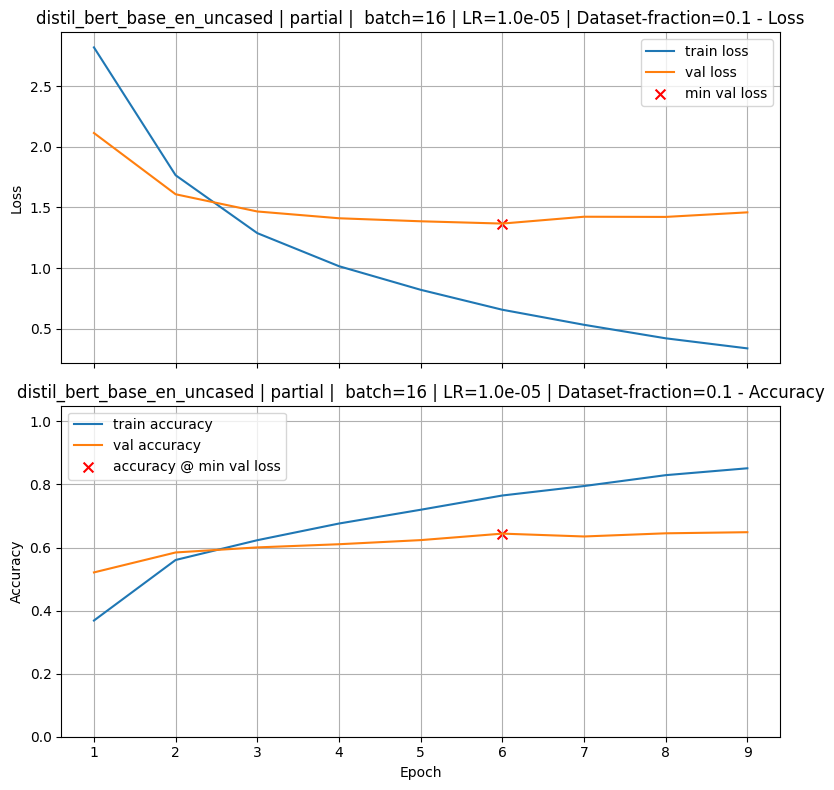

Final Training Loss:            0.3360
Final Training  accuracy:    0.8513
Final Validation Loss:          1.4599
Final Validation  accuracy:  0.6486
Min Validation Loss:            1.3672 (Epoch 6)
Accuracy @ Min Val Loss:      0.6441

Test metrics:
  loss: 1.4656
  accuracy: 0.6242

Execution Time: 4m 19s
Peak Memory Usage: 8056.96 MB

Summary of run:
  title: distil_bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=4m 19s | Mem=8056.96MB
  best_epoch_by_val_loss: 6
  min_val_loss: 1.3671690225601196
  accuracy_at_min_val_loss: 0.6440762877464294
  made_internal_val: False
  test_metrics: {'loss': 1.4656192064285278, 'accuracy': 0.624152660369873}
  train_time_sec: 259.7316982746124
  peak_memory_mb: 8056.95703125
Test accuracy (from summary): 0.6242
Test macro-F1 (recalculated): 0.5563


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=full
-

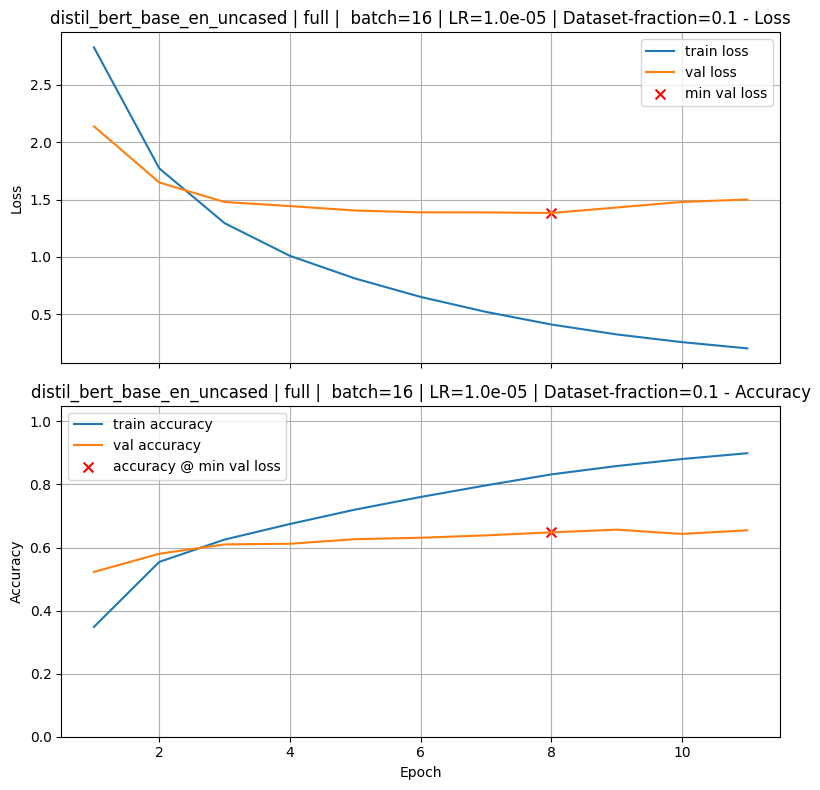

Final Training Loss:            0.2035
Final Training  accuracy:    0.8991
Final Validation Loss:          1.5002
Final Validation  accuracy:  0.6546
Min Validation Loss:            1.3830 (Epoch 8)
Accuracy @ Min Val Loss:      0.6481

Test metrics:
  loss: 1.5143
  accuracy: 0.6257

Execution Time: 4m 42s
Peak Memory Usage: 8827.59 MB

Summary of run:
  title: distil_bert_base_en_uncased | full |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=4m 42s | Mem=8827.59MB
  best_epoch_by_val_loss: 8
  min_val_loss: 1.3829801082611084
  accuracy_at_min_val_loss: 0.6480923891067505
  made_internal_val: False
  test_metrics: {'loss': 1.5143275260925293, 'accuracy': 0.6256590485572815}
  train_time_sec: 282.989919424057
  peak_memory_mb: 8827.58984375
Test accuracy (from summary): 0.6257
Test macro-F1 (recalculated): 0.5544


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=32  lr=1.0e-05  strategy=freeze
--

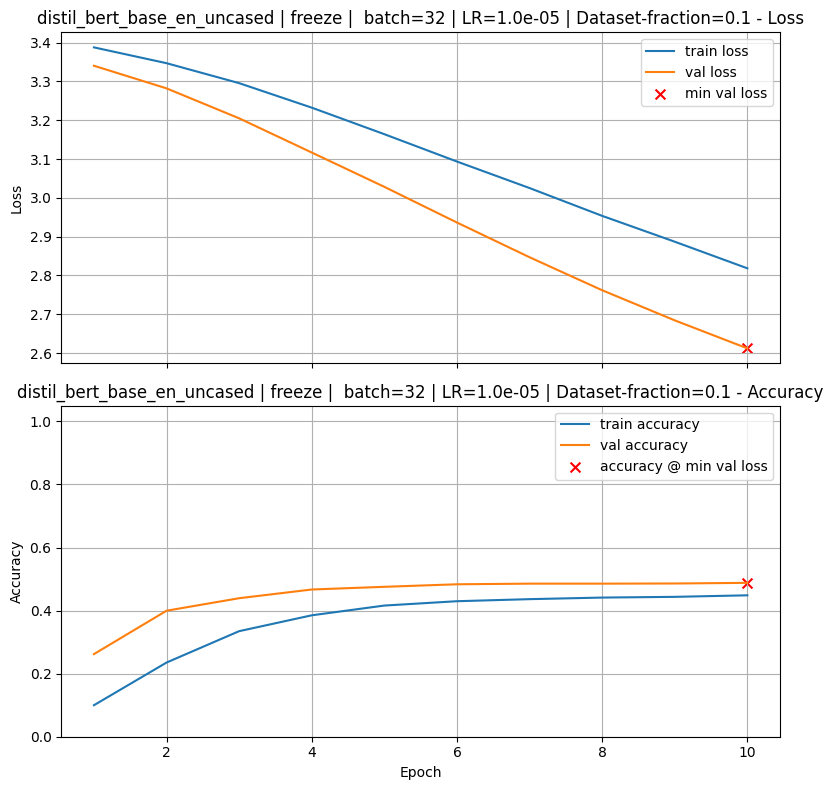

Final Training Loss:            2.8185
Final Training  accuracy:    0.4485
Final Validation Loss:          2.6122
Final Validation  accuracy:  0.4880
Min Validation Loss:            2.6122 (Epoch 10)
Accuracy @ Min Val Loss:      0.4880

Test metrics:
  loss: 2.6305
  accuracy: 0.4888

Execution Time: 1m 39s
Peak Memory Usage: 9360.16 MB

Summary of run:
  title: distil_bert_base_en_uncased | freeze |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=1m 39s | Mem=9360.16MB
  best_epoch_by_val_loss: 10
  min_val_loss: 2.61222505569458
  accuracy_at_min_val_loss: 0.4879518151283264
  made_internal_val: False
  test_metrics: {'loss': 2.6304547786712646, 'accuracy': 0.48882752656936646}
  train_time_sec: 99.07210397720337
  peak_memory_mb: 9360.15625
Test accuracy (from summary): 0.4888
Test macro-F1 (recalculated): 0.3455


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=32  lr=1.0e-05  strategy=partial


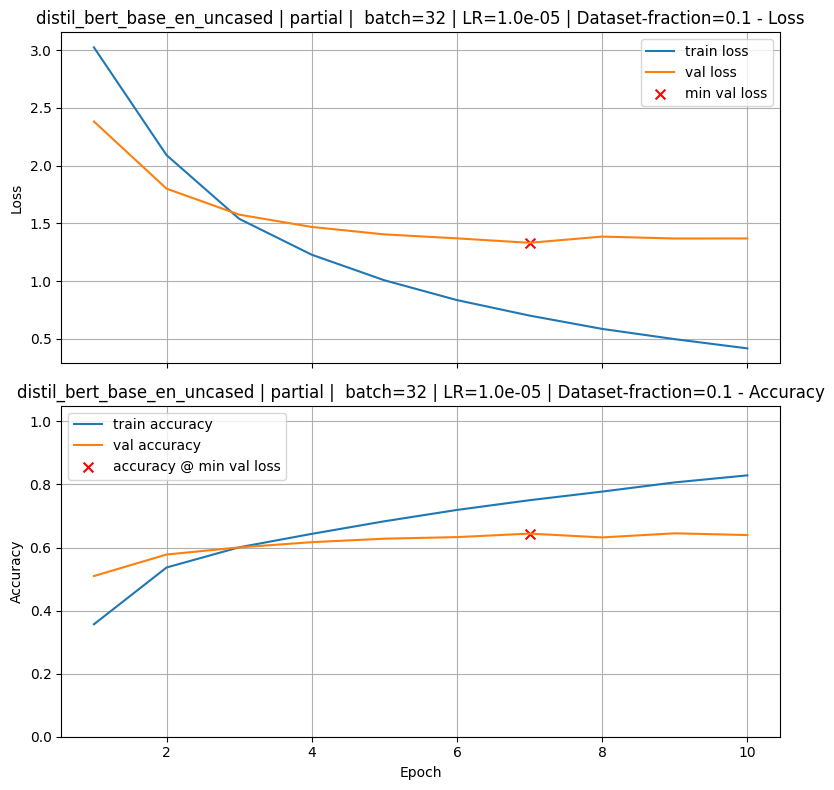

Final Training Loss:            0.4177
Final Training  accuracy:    0.8288
Final Validation Loss:          1.3691
Final Validation  accuracy:  0.6396
Min Validation Loss:            1.3315 (Epoch 7)
Accuracy @ Min Val Loss:      0.6441

Test metrics:
  loss: 1.4725
  accuracy: 0.6124

Execution Time: 4m 18s
Peak Memory Usage: 9841.35 MB

Summary of run:
  title: distil_bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=4m 18s | Mem=9841.35MB
  best_epoch_by_val_loss: 7
  min_val_loss: 1.3314851522445679
  accuracy_at_min_val_loss: 0.6440762877464294
  made_internal_val: False
  test_metrics: {'loss': 1.472461462020874, 'accuracy': 0.6123524904251099}
  train_time_sec: 258.20352959632874
  peak_memory_mb: 9841.34765625
Test accuracy (from summary): 0.6124
Test macro-F1 (recalculated): 0.5414


--------------------------------------------------------------------------------
Running: model=distil_bert_base_en_uncased  batch=32  lr=1.0e-05  strategy=full


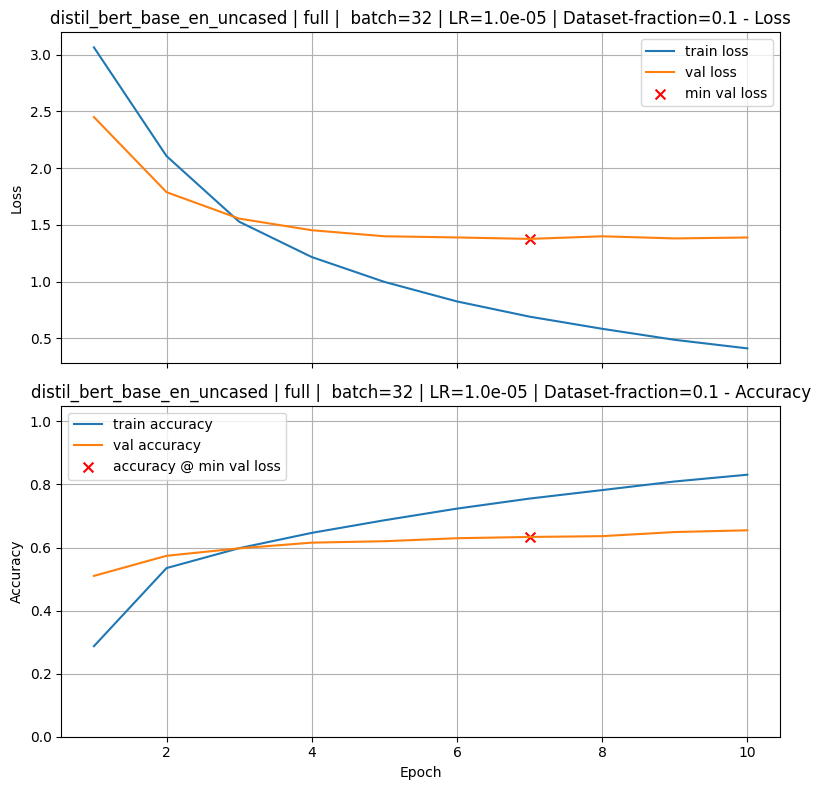

Final Training Loss:            0.4126
Final Training  accuracy:    0.8309
Final Validation Loss:          1.3895
Final Validation  accuracy:  0.6546
Min Validation Loss:            1.3771 (Epoch 7)
Accuracy @ Min Val Loss:      0.6335

Test metrics:
  loss: 1.5130
  accuracy: 0.6041

Execution Time: 3m 54s
Peak Memory Usage: 10563.84 MB

Summary of run:
  title: distil_bert_base_en_uncased | full |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=3m 54s | Mem=10563.84MB
  best_epoch_by_val_loss: 7
  min_val_loss: 1.377126693725586
  accuracy_at_min_val_loss: 0.6335341334342957
  made_internal_val: False
  test_metrics: {'loss': 1.5130345821380615, 'accuracy': 0.6040672659873962}
  train_time_sec: 234.00491786003113
  peak_memory_mb: 10563.83984375
Test accuracy (from summary): 0.6041
Test macro-F1 (recalculated): 0.5354


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=8  lr=1.0e-05  strategy=freeze
------

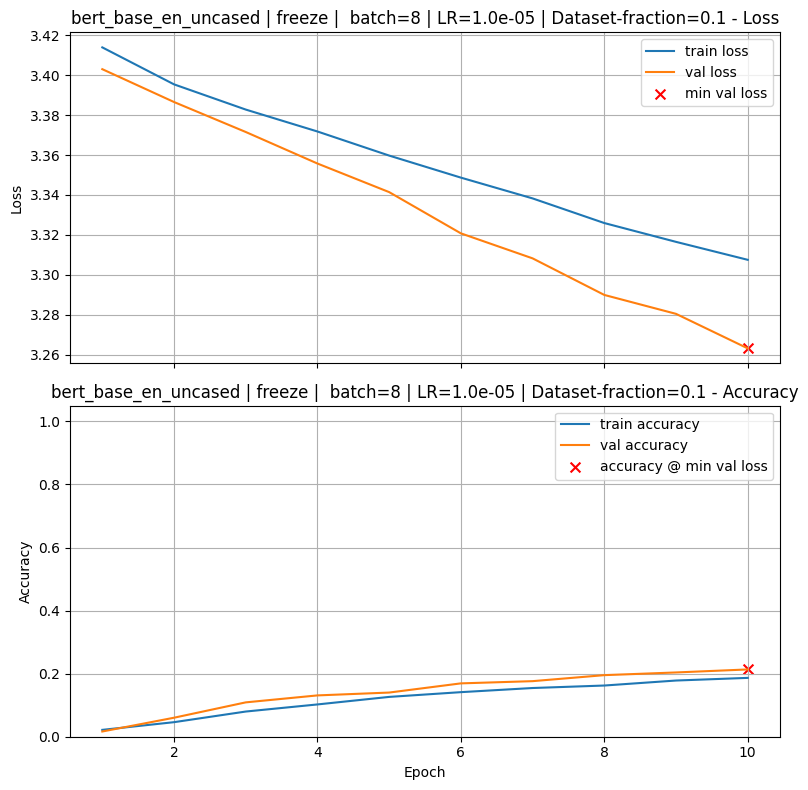

Final Training Loss:            3.3075
Final Training  accuracy:    0.1866
Final Validation Loss:          3.2631
Final Validation  accuracy:  0.2134
Min Validation Loss:            3.2631 (Epoch 10)
Accuracy @ Min Val Loss:      0.2134

Test metrics:
  loss: 3.2604
  accuracy: 0.2305

Execution Time: 4m 21s
Peak Memory Usage: 11759.56 MB

Summary of run:
  title: bert_base_en_uncased | freeze |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=4m 21s | Mem=11759.56MB
  best_epoch_by_val_loss: 10
  min_val_loss: 3.26308012008667
  accuracy_at_min_val_loss: 0.21335341036319733
  made_internal_val: False
  test_metrics: {'loss': 3.260392904281616, 'accuracy': 0.23047953844070435}
  train_time_sec: 261.2903871536255
  peak_memory_mb: 11759.55859375
Test accuracy (from summary): 0.2305
Test macro-F1 (recalculated): 0.1337


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=8  lr=1.0e-05  strategy=partial
----------

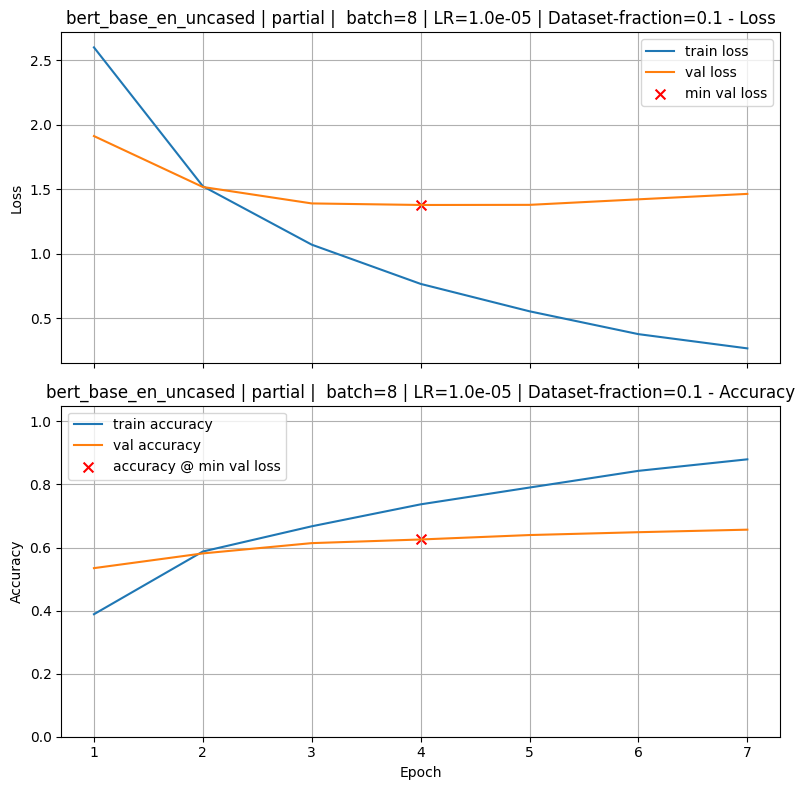

Final Training Loss:            0.2660
Final Training  accuracy:    0.8797
Final Validation Loss:          1.4647
Final Validation  accuracy:  0.6566
Min Validation Loss:            1.3786 (Epoch 4)
Accuracy @ Min Val Loss:      0.6255

Test metrics:
  loss: 1.4680
  accuracy: 0.6216

Execution Time: 8m 15s
Peak Memory Usage: 12668.93 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=8m 15s | Mem=12668.93MB
  best_epoch_by_val_loss: 4
  min_val_loss: 1.3786234855651855
  accuracy_at_min_val_loss: 0.6255019903182983
  made_internal_val: False
  test_metrics: {'loss': 1.4680310487747192, 'accuracy': 0.621641993522644}
  train_time_sec: 495.22023701667786
  peak_memory_mb: 12668.9296875
Test accuracy (from summary): 0.6216
Test macro-F1 (recalculated): 0.5588


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=8  lr=1.0e-05  strategy=full
--------------

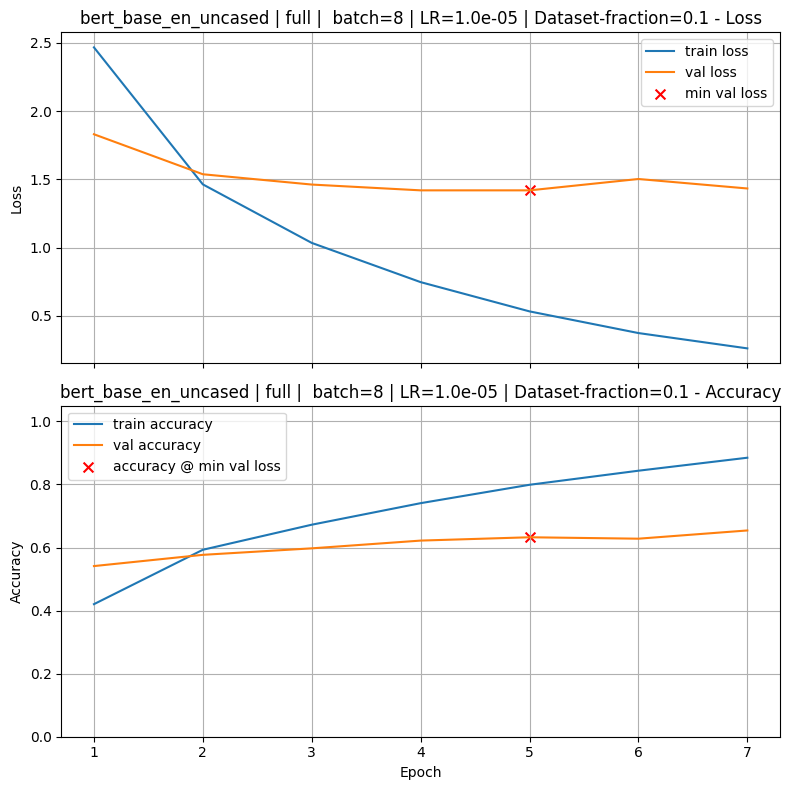

Final Training Loss:            0.2610
Final Training  accuracy:    0.8848
Final Validation Loss:          1.4325
Final Validation  accuracy:  0.6541
Min Validation Loss:            1.4188 (Epoch 5)
Accuracy @ Min Val Loss:      0.6325

Test metrics:
  loss: 1.4951
  accuracy: 0.6111

Execution Time: 7m 38s
Peak Memory Usage: 14124.80 MB

Summary of run:
  title: bert_base_en_uncased | full |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=7m 38s | Mem=14124.80MB
  best_epoch_by_val_loss: 5
  min_val_loss: 1.4187641143798828
  accuracy_at_min_val_loss: 0.6325300931930542
  made_internal_val: False
  test_metrics: {'loss': 1.49507474899292, 'accuracy': 0.6110971570014954}
  train_time_sec: 458.41397166252136
  peak_memory_mb: 14124.8046875
Test accuracy (from summary): 0.6111
Test macro-F1 (recalculated): 0.5471


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=freeze
---------------

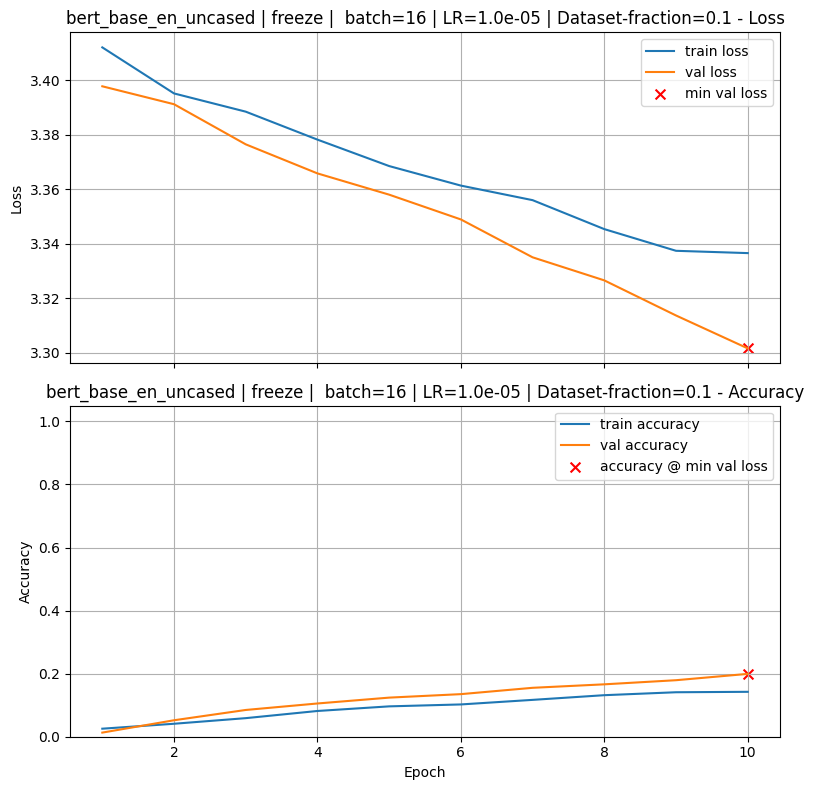

Final Training Loss:            3.3366
Final Training  accuracy:    0.1424
Final Validation Loss:          3.3015
Final Validation  accuracy:  0.1993
Min Validation Loss:            3.3015 (Epoch 10)
Accuracy @ Min Val Loss:      0.1993

Test metrics:
  loss: 3.2987
  accuracy: 0.2044

Execution Time: 3m 23s
Peak Memory Usage: 14980.81 MB

Summary of run:
  title: bert_base_en_uncased | freeze |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=3m 23s | Mem=14980.81MB
  best_epoch_by_val_loss: 10
  min_val_loss: 3.301544427871704
  accuracy_at_min_val_loss: 0.19929718971252441
  made_internal_val: False
  test_metrics: {'loss': 3.2987048625946045, 'accuracy': 0.20436856150627136}
  train_time_sec: 203.3628785610199
  peak_memory_mb: 14980.8125
Test accuracy (from summary): 0.2044
Test macro-F1 (recalculated): 0.1181


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=partial
----------

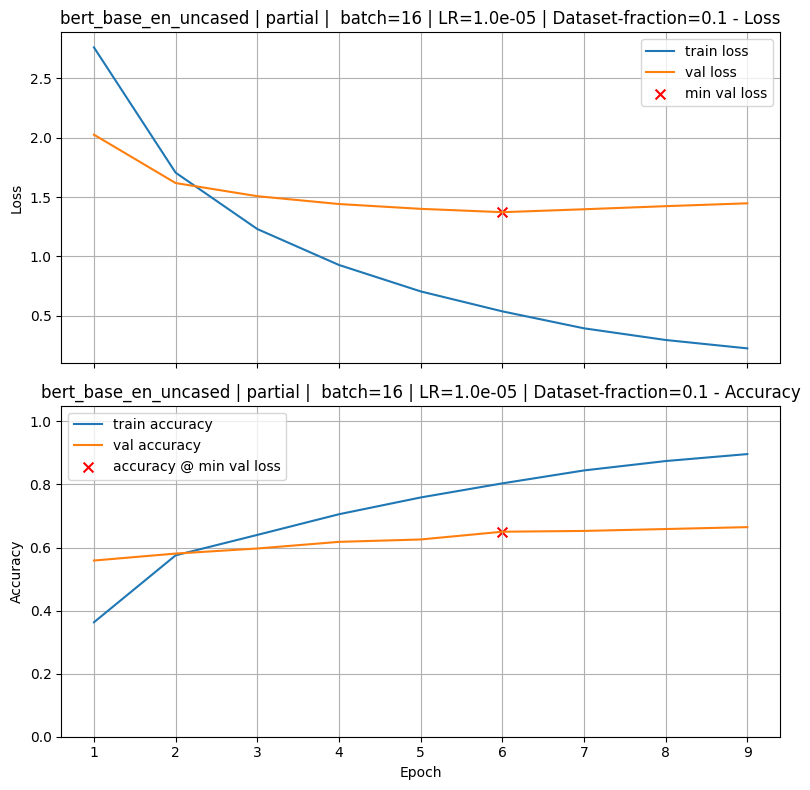

Final Training Loss:            0.2238
Final Training  accuracy:    0.8963
Final Validation Loss:          1.4471
Final Validation  accuracy:  0.6647
Min Validation Loss:            1.3722 (Epoch 6)
Accuracy @ Min Val Loss:      0.6501

Test metrics:
  loss: 1.4471
  accuracy: 0.6412

Execution Time: 7m 11s
Peak Memory Usage: 15796.99 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=7m 11s | Mem=15796.99MB
  best_epoch_by_val_loss: 6
  min_val_loss: 1.372191309928894
  accuracy_at_min_val_loss: 0.6501004099845886
  made_internal_val: False
  test_metrics: {'loss': 1.4470773935317993, 'accuracy': 0.6412252187728882}
  train_time_sec: 431.310800075531
  peak_memory_mb: 15796.9921875
Test accuracy (from summary): 0.6412
Test macro-F1 (recalculated): 0.5723


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=full
--------------

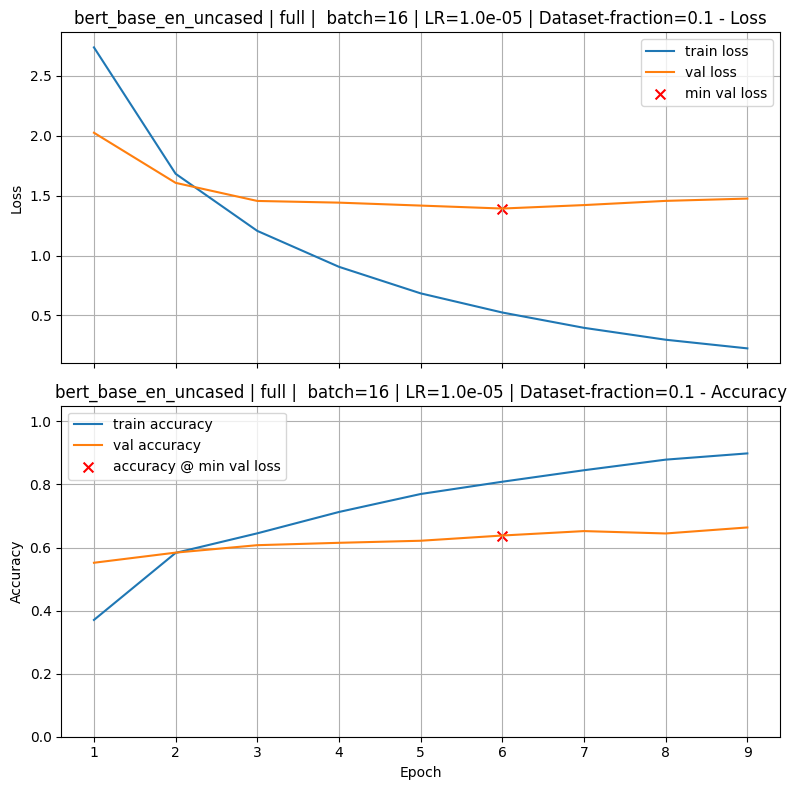

Final Training Loss:            0.2256
Final Training  accuracy:    0.8985
Final Validation Loss:          1.4750
Final Validation  accuracy:  0.6637
Min Validation Loss:            1.3920 (Epoch 6)
Accuracy @ Min Val Loss:      0.6381

Test metrics:
  loss: 1.4341
  accuracy: 0.6425

Execution Time: 7m 03s
Peak Memory Usage: 17054.32 MB

Summary of run:
  title: bert_base_en_uncased | full |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=7m 03s | Mem=17054.32MB
  best_epoch_by_val_loss: 6
  min_val_loss: 1.391978144645691
  accuracy_at_min_val_loss: 0.638052225112915
  made_internal_val: False
  test_metrics: {'loss': 1.4340933561325073, 'accuracy': 0.6424805521965027}
  train_time_sec: 423.3944504261017
  peak_memory_mb: 17054.31640625
Test accuracy (from summary): 0.6425
Test macro-F1 (recalculated): 0.5743


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=32  lr=1.0e-05  strategy=freeze
--------------

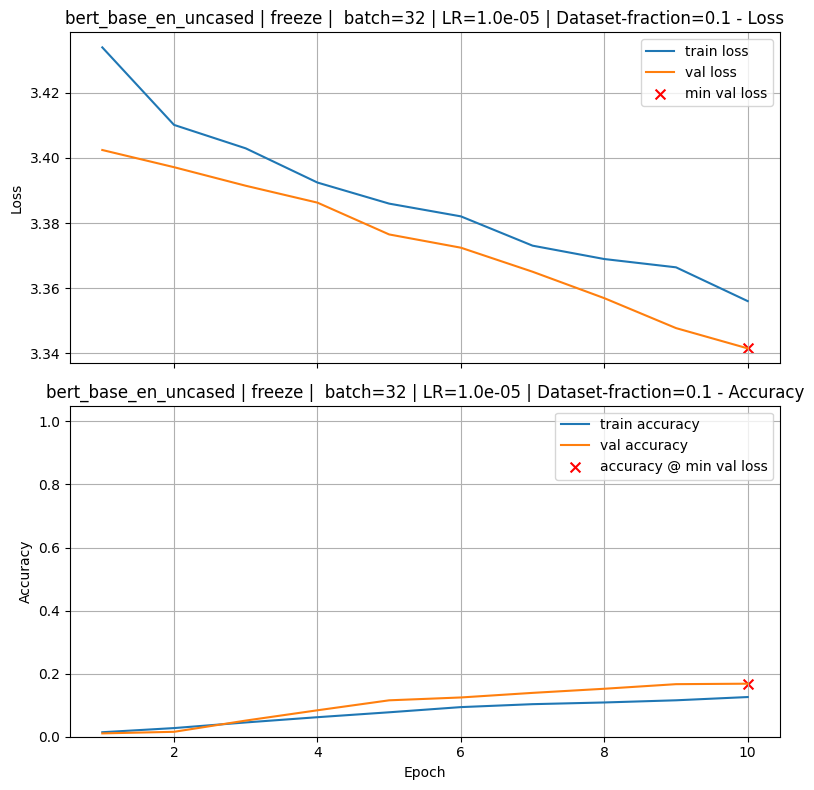

Final Training Loss:            3.3560
Final Training  accuracy:    0.1258
Final Validation Loss:          3.3415
Final Validation  accuracy:  0.1682
Min Validation Loss:            3.3415 (Epoch 10)
Accuracy @ Min Val Loss:      0.1682

Test metrics:
  loss: 3.3401
  accuracy: 0.1632

Execution Time: 2m 49s
Peak Memory Usage: 17659.20 MB

Summary of run:
  title: bert_base_en_uncased | freeze |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=2m 49s | Mem=17659.20MB
  best_epoch_by_val_loss: 10
  min_val_loss: 3.3415005207061768
  accuracy_at_min_val_loss: 0.168172687292099
  made_internal_val: False
  test_metrics: {'loss': 3.3401381969451904, 'accuracy': 0.16319356858730316}
  train_time_sec: 169.22977018356323
  peak_memory_mb: 17659.1953125
Test accuracy (from summary): 0.1632
Test macro-F1 (recalculated): 0.0839


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=32  lr=1.0e-05  strategy=partial
-------

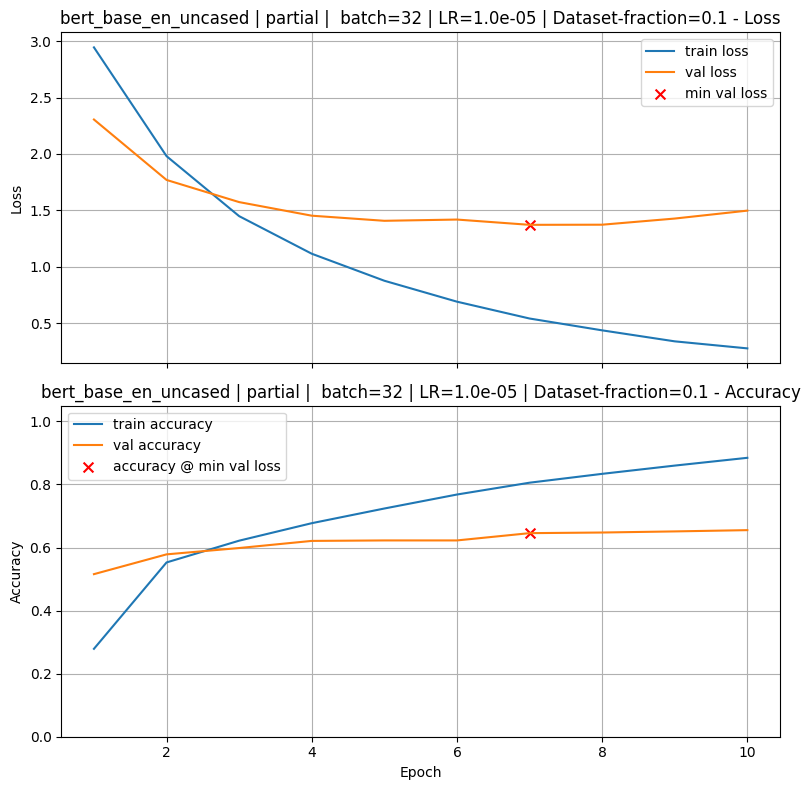

Final Training Loss:            0.2786
Final Training  accuracy:    0.8845
Final Validation Loss:          1.4983
Final Validation  accuracy:  0.6551
Min Validation Loss:            1.3726 (Epoch 7)
Accuracy @ Min Val Loss:      0.6456

Test metrics:
  loss: 1.4254
  accuracy: 0.6447

Execution Time: 6m 27s
Peak Memory Usage: 18585.18 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=6m 27s | Mem=18585.18MB
  best_epoch_by_val_loss: 7
  min_val_loss: 1.3725898265838623
  accuracy_at_min_val_loss: 0.6455823183059692
  made_internal_val: False
  test_metrics: {'loss': 1.4253876209259033, 'accuracy': 0.6447401642799377}
  train_time_sec: 387.30264616012573
  peak_memory_mb: 18585.1796875
Test accuracy (from summary): 0.6447
Test macro-F1 (recalculated): 0.5716


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=32  lr=1.0e-05  strategy=full
-----------

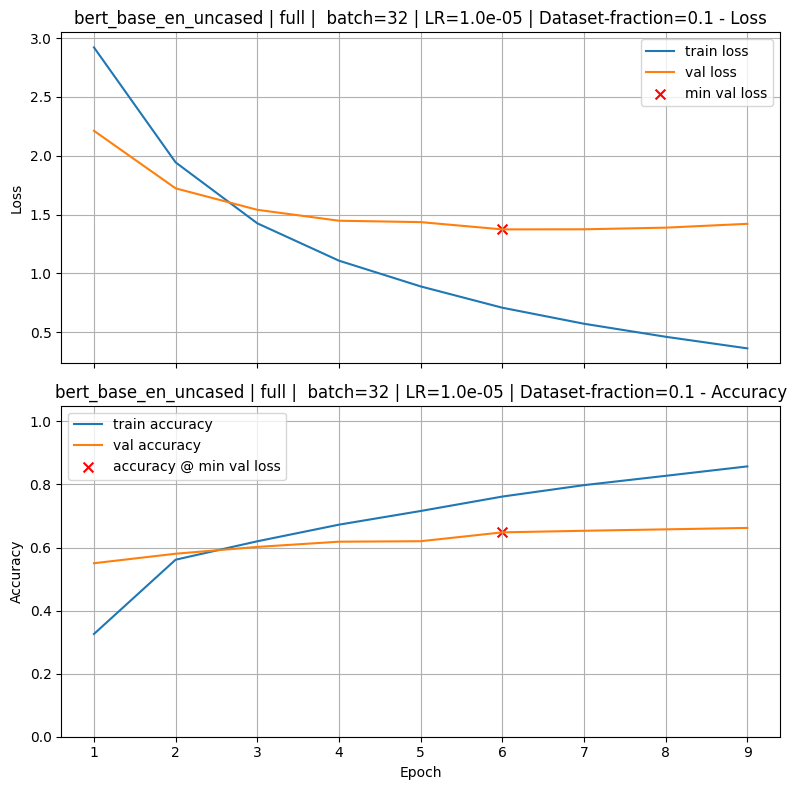

Final Training Loss:            0.3624
Final Training  accuracy:    0.8573
Final Validation Loss:          1.4213
Final Validation  accuracy:  0.6621
Min Validation Loss:            1.3740 (Epoch 6)
Accuracy @ Min Val Loss:      0.6481

Test metrics:
  loss: 1.4633
  accuracy: 0.6242

Execution Time: 5m 55s
Peak Memory Usage: 20164.46 MB

Summary of run:
  title: bert_base_en_uncased | full |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1 | Time=5m 55s | Mem=20164.46MB
  best_epoch_by_val_loss: 6
  min_val_loss: 1.3739650249481201
  accuracy_at_min_val_loss: 0.6480923891067505
  made_internal_val: False
  test_metrics: {'loss': 1.4633041620254517, 'accuracy': 0.624152660369873}
  train_time_sec: 355.45180463790894
  peak_memory_mb: 20164.46484375
Test accuracy (from summary): 0.6242
Test macro-F1 (recalculated): 0.5513



==== Experiment Loop for subset_frac=0.1 complete ====



In [62]:
'''
if 'label_names' not in globals():
    label_names = ['ARTS', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'HOME & LIVING', 'MEDIA', 'MONEY', 'PARENTING', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WOMEN', 'WORLDPOST']
if 'num_classes' not in globals():
    num_classes = len(label_names)
'''

# Execute with fraction =0.1
subset_frac = 0.1
current_results, current_subset_stats = run_experiment_loop(
        current_subset_frac = subset_frac,
        model_configs_list = ALL_MODEL_CONFIGS, # Use the globally defined model configurations
        max_epochs = EPOCHS,
        n_partial_layers = N_PARTIAL_LAYERS,
        eval_batch_size = EVAL_BATCH,
        all_dataset = all_ds,
        num_classes_global = num_classes,
        label_names_global = label_names,
        class_weights_global = class_weights
    )
all_experiment_results.update(current_results)
all_subset_stats.extend(current_subset_stats)

In [63]:
print_results(results)

Sorting results by: accuracy_at_min_val_loss

bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6501  (best epoch=6)
distil_bert_base_en_uncased | full |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6481  (best epoch=8)
bert_base_en_uncased | full |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6481  (best epoch=6)
bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6456  (best epoch=7)
distil_bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6441  (best epoch=6)
distil_bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6441  (best epoch=7)
distil_bert_base_en_uncased | partial |  batch=8 | LR=1.0e-05 | Dataset-fraction=0.1  0.6431  (best epoch=6)
bert_base_en_uncased | full |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6381  (best epoch=6)
distil_bert_base_en_uncased | full |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6335  (best epoch=7)
disti

In [64]:

if 'all_subset_stats' in globals() and len(all_subset_stats) > 0:
    summary_df = pd.DataFrame(all_subset_stats)
    # Sorting to ensure consistent view if not already sorted
    summary_df = summary_df.sort_values(by="test_f1_macro", ascending=False)
    display(summary_df)
else:
    print("Dataframe doesnt have summary info")

,model,strategy,batch,lr,val_acc_at_min_loss,min_val_loss,test_loss,test_acc,test_f1_macro,elapsed_sec,peak_memory_mb,dataset_fraction
14,bert_base_en_uncased,full,16,0.00001,0.638052,1.391978,1.434093,0.642481,0.574336,423.394450,17054.316406,0.1
13,bert_base_en_uncased,partial,16,0.00001,0.650100,1.372191,1.447077,0.641225,0.572350,431.310800,15796.992188,0.1
16,bert_base_en_uncased,partial,32,0.00001,0.645582,1.372590,1.425388,0.644740,0.571628,387.302646,18585.179688,0.1
10,bert_base_en_uncased,partial,8,0.00001,0.625502,1.378623,1.468031,0.621642,0.558829,495.220237,12668.929688,0.1
4,distil_bert_base_en_uncased,partial,16,0.00001,0.644076,1.367169,1.465619,0.624153,0.556265,259.731698,8056.957031,0.1
5,distil_bert_base_en_uncased,full,16,0.00001,0.648092,1.382980,1.514328,0.625659,0.554441,282.989919,8827.589844,0.1
17,bert_base_en_uncased,full,32,0.00001,0.648092,1.373965,1.463304,0.624153,0.551334,355.451805,20164.464844,0.1
2,distil_bert_base_en_uncased,full,8,0.00001,0.633032,1.422798,1.546487,0.616621,0.550971,321.536909,7197.750000,0.1
1,distil_bert_base_en_uncased,partial,8,0.00001,0.643072,1.354240,1.499595,0.619382,0.547550,328.358058,6344.324219,0.1
11,bert_base_en_uncased,full,8,0.00001,0.632530,1.418764,1.495075,0.611097,0.547116,458.413972,14124.804688,0.1


### **Based on the above experimentation results we decided the best parameters and the model so we can finetune**

### **Finetuning** - We will use BERT with partial freeze strategy batch size of 16 as its partial freeze and moderate batch size. It has very small difference in f1-Macro compared to full 32 and same for validation accuracy at minimal loss. The two configurations which are giveing slightly better perfromance is full training which the training time will increase substantilly as we train for larger proprtion of dataset. Our expectation is that as we increase the training dataset propertion the fi-macro and accuracy both will increase.  So we feel this is the best optimized model config for fine tuning in the next step


	model (bert_base_en_uncased)	strategy(partial)	batch(16)	lr(0.00001)	val_acc_at_min_loss(0.650100)	min_val_loss(1.372191)	test_loss(1.447077)	test_acc(0.641225)	test_f1_macro(0.572350)	elapsed_sec(431.31)	peak_memory_mb(15796.992188	)




In [66]:
ALL_MODEL_CONFIGS = []
model_n = "bert_base_en_uncased"
partial_lr = 1e-5
ALL_MODEL_CONFIGS.append({"name": model_n, "batch": 16, "lr": partial_lr, "strategy": "partial", "unfreeze_layers": N_PARTIAL_LAYERS})


----------------------------------------------------------------------------------------------------
RUNNING EXPERIMENTS FOR DATASET SUBSET FRACTION: 0.5
----------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=partial
--------------------------------------------------------------------------------

Using subset of size 99573 (from total 199146) for this run.
Split sizes: Train=69700, Val=9958, Test=19915
Train counts: 69700 samples
Strategy: PARTIAL (unfroze last 2 layers of backbone).

=== bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.5 ===

Epoch 1/15
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 298s 51ms/step - accuracy: 0.4207 - loss: 2.3380 - val_accuracy: 0.5997 - val_loss: 1.4584 - learning_rate: 1.0000e-05
Epoch 2/15
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 155s 35ms/step - acc

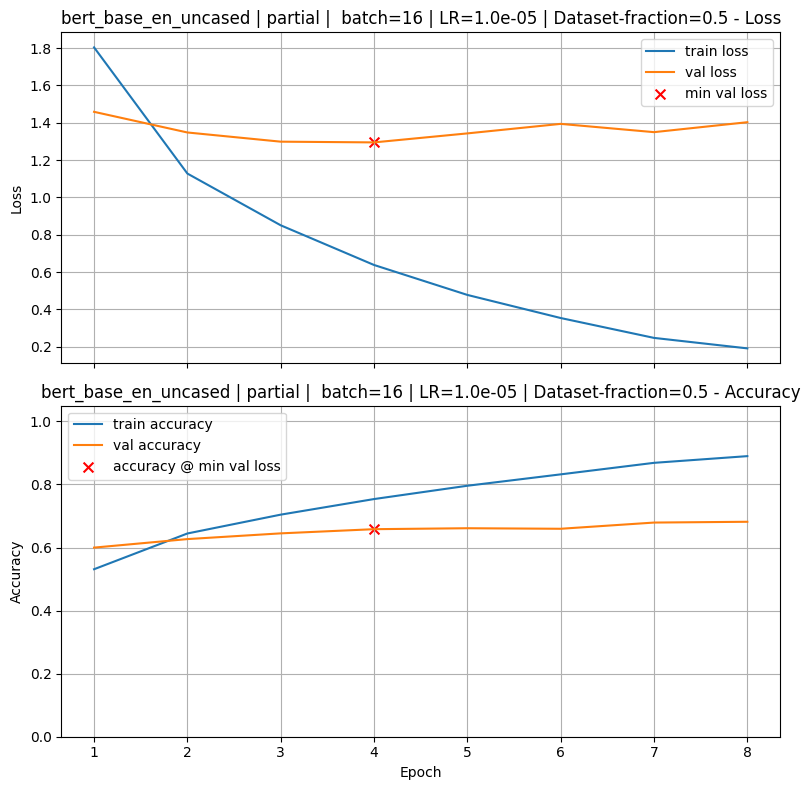

Final Training Loss:            0.1908
Final Training  accuracy:    0.8898
Final Validation Loss:          1.4027
Final Validation  accuracy:  0.6817
Min Validation Loss:            1.2945 (Epoch 4)
Accuracy @ Min Val Loss:      0.6582

Test metrics:
  loss: 1.2991
  accuracy: 0.6527

Execution Time: 22m 13s
Peak Memory Usage: 21243.38 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.5 | Time=22m 13s | Mem=21243.38MB
  best_epoch_by_val_loss: 4
  min_val_loss: 1.2945460081100464
  accuracy_at_min_val_loss: 0.6581642627716064
  made_internal_val: False
  test_metrics: {'loss': 1.299062967300415, 'accuracy': 0.6527240872383118}
  train_time_sec: 1333.6087100505829
  peak_memory_mb: 21243.37890625
Test accuracy (from summary): 0.6527
Test macro-F1 (recalculated): 0.6042



==== Experiment Loop for subset_frac=0.5 complete ====



In [67]:
#Execute with fraction =0.5
subset_frac = 0.5
current_results, current_subset_stats = run_experiment_loop(
        current_subset_frac = subset_frac,
        model_configs_list = ALL_MODEL_CONFIGS, # Use the globally defined model configurations
        max_epochs = EPOCHS,
        n_partial_layers = N_PARTIAL_LAYERS,
        eval_batch_size = 16,
        all_dataset = all_ds,
        num_classes_global = num_classes,
        label_names_global = label_names,
        class_weights_global = class_weights,
        use_reduce_lr = True ,
        patience = 4                 #doing reduced patience so as the reduced lr kicks in
    )
all_experiment_results.update(current_results)
all_subset_stats.extend(current_subset_stats)


----------------------------------------------------------------------------------------------------
RUNNING EXPERIMENTS FOR DATASET SUBSET FRACTION: 0.75
----------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=partial
--------------------------------------------------------------------------------

Using subset of size 149359 (from total 199146) for this run.
Split sizes: Train=104551, Val=14936, Test=29872
Train counts: 104551 samples
Strategy: PARTIAL (unfroze last 2 layers of backbone).

=== bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.75 ===

Epoch 1/15
6535/6535 ━━━━━━━━━━━━━━━━━━━━ 382s 45ms/step - accuracy: 0.4546 - loss: 2.1022 - val_accuracy: 0.6183 - val_loss: 1.3716 - learning_rate: 1.0000e-05
Epoch 2/15
6535/6535 ━━━━━━━━━━━━━━━━━━━━ 230s 35ms/step

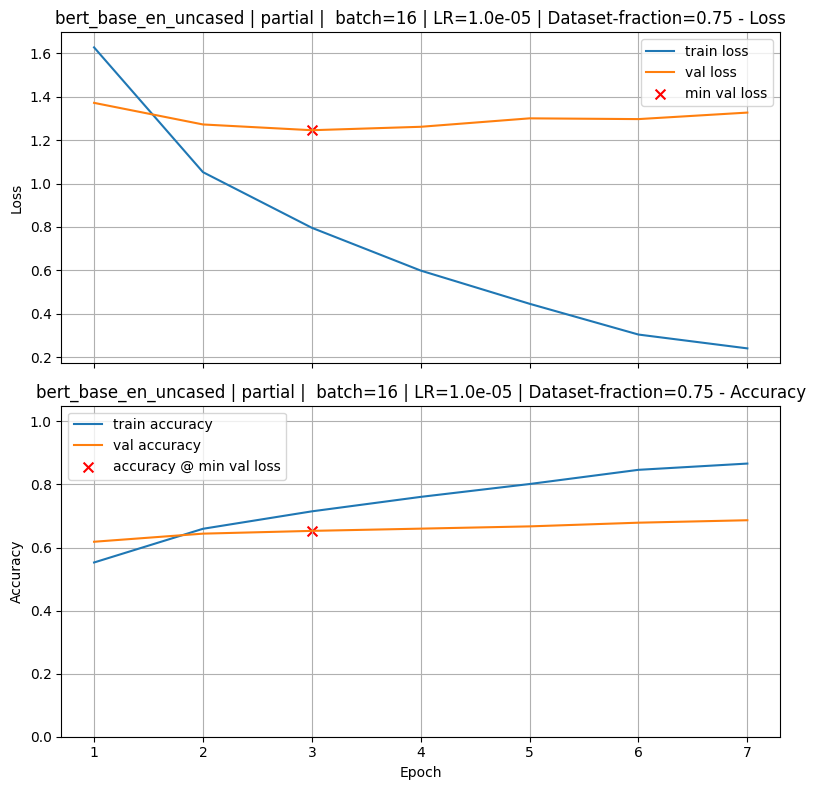

Final Training Loss:            0.2408
Final Training  accuracy:    0.8662
Final Validation Loss:          1.3269
Final Validation  accuracy:  0.6865
Min Validation Loss:            1.2457 (Epoch 3)
Accuracy @ Min Val Loss:      0.6528

Test metrics:
  loss: 1.2349
  accuracy: 0.6549

Execution Time: 29m 28s
Peak Memory Usage: 22192.96 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.75 | Time=29m 28s | Mem=22192.96MB
  best_epoch_by_val_loss: 3
  min_val_loss: 1.245652198791504
  accuracy_at_min_val_loss: 0.6527852416038513
  made_internal_val: False
  test_metrics: {'loss': 1.2349311113357544, 'accuracy': 0.654894232749939}
  train_time_sec: 1768.0044355392456
  peak_memory_mb: 22192.96484375
Test accuracy (from summary): 0.6549
Test macro-F1 (recalculated): 0.6092



==== Experiment Loop for subset_frac=0.75 complete ====



In [68]:
#Execute with fraction =0.75

subset_frac = 0.75
current_results, current_subset_stats = run_experiment_loop(
        current_subset_frac = subset_frac,
        model_configs_list = ALL_MODEL_CONFIGS, # Use the globally defined model configurations
        max_epochs = EPOCHS,
        n_partial_layers = N_PARTIAL_LAYERS,
        eval_batch_size = 16,
        all_dataset = all_ds,
        num_classes_global = num_classes,
        label_names_global = label_names,
        class_weights_global = class_weights,
        use_reduce_lr = True ,
        patience = 4                 #doing reduced patience so as the reduced lr kicks in
    )
all_experiment_results.update(current_results)
all_subset_stats.extend(current_subset_stats)


----------------------------------------------------------------------------------------------------
RUNNING EXPERIMENTS FOR DATASET SUBSET FRACTION: 1
----------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=1.0e-05  strategy=partial
--------------------------------------------------------------------------------

Using subset of size 199146 (from total 199146) for this run.
Split sizes: Train=139401, Val=19915, Test=39830
Train counts: 139401 samples
Strategy: PARTIAL (unfroze last 2 layers of backbone).

=== bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=1 ===

Epoch 1/15
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 459s 43ms/step - accuracy: 0.4855 - loss: 1.9812 - val_accuracy: 0.6233 - val_loss: 1.3206 - learning_rate: 1.0000e-05
Epoch 2/15
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 307s 35ms/step - acc

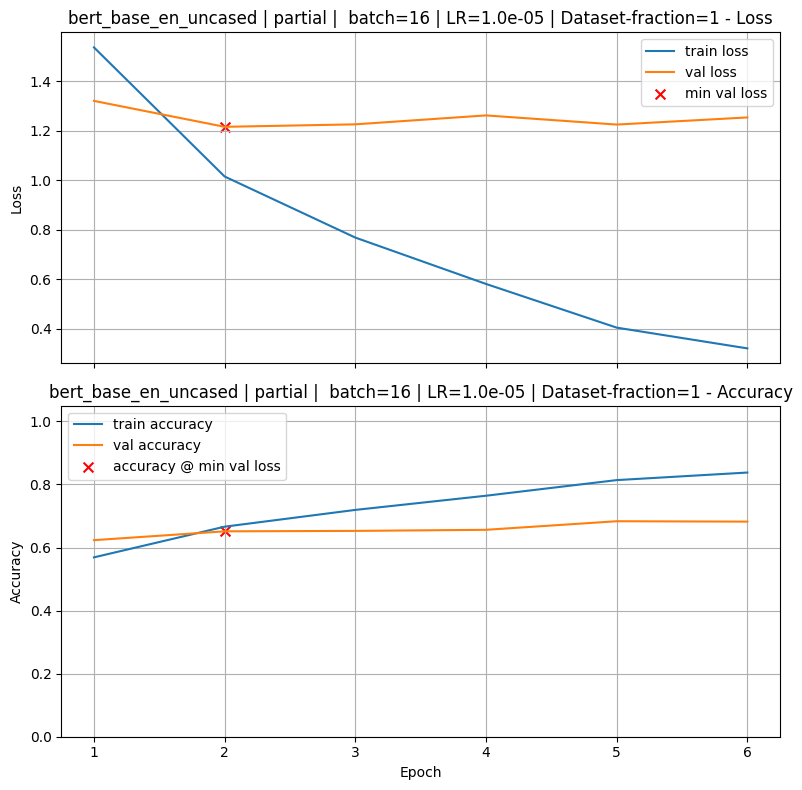

Final Training Loss:            0.3201
Final Training  accuracy:    0.8378
Final Validation Loss:          1.2537
Final Validation  accuracy:  0.6821
Min Validation Loss:            1.2158 (Epoch 2)
Accuracy @ Min Val Loss:      0.6514

Test metrics:
  loss: 1.2071
  accuracy: 0.6526

Execution Time: 33m 29s
Peak Memory Usage: 23167.75 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=1 | Time=33m 29s | Mem=23167.75MB
  best_epoch_by_val_loss: 2
  min_val_loss: 1.2157808542251587
  accuracy_at_min_val_loss: 0.6513683199882507
  made_internal_val: False
  test_metrics: {'loss': 1.2070506811141968, 'accuracy': 0.6525734663009644}
  train_time_sec: 2009.8419539928436
  peak_memory_mb: 23167.75390625
Test accuracy (from summary): 0.6526
Test macro-F1 (recalculated): 0.6058



==== Experiment Loop for subset_frac=1 complete ====



In [69]:
#Execute with whole data
subset_frac = 1

current_results, current_subset_stats = run_experiment_loop(
        current_subset_frac = subset_frac,
        model_configs_list = ALL_MODEL_CONFIGS, # Use the globally defined model configurations
        max_epochs = EPOCHS,
        n_partial_layers = N_PARTIAL_LAYERS,
        eval_batch_size = 16,
        all_dataset = all_ds,
        num_classes_global = num_classes,
        label_names_global = label_names,
        class_weights_global = class_weights,
        use_reduce_lr = True ,
        patience = 4                 #doing reduced patience so as the reduced lr kicks in
    )
all_experiment_results.update(current_results)
all_subset_stats.extend(current_subset_stats)

In [70]:
print_results(results)

Sorting results by: accuracy_at_min_val_loss

bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.5  0.6582  (best epoch=4)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.75  0.6528  (best epoch=3)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=1  0.6514  (best epoch=2)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6501  (best epoch=6)
distil_bert_base_en_uncased | full |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6481  (best epoch=8)
bert_base_en_uncased | full |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6481  (best epoch=6)
bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6456  (best epoch=7)
distil_bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6441  (best epoch=6)
distil_bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6441  (best epoch=7)
distil_bert_b

In [71]:
if 'all_subset_stats' in globals() and len(all_subset_stats) > 0:
    summary_df = pd.DataFrame(all_subset_stats)
    # Sorting to ensure consistent view if not already sorted
    summary_df = summary_df.sort_values(by="test_f1_macro", ascending=False)
    display(summary_df)
else:
    print("Dataframe doesnt have summary info")

,model,strategy,batch,lr,val_acc_at_min_loss,min_val_loss,test_loss,test_acc,test_f1_macro,elapsed_sec,peak_memory_mb,dataset_fraction
19,bert_base_en_uncased,partial,16,0.00001,0.652785,1.245652,1.234931,0.654894,0.609215,1768.004436,22192.964844,0.75
20,bert_base_en_uncased,partial,16,0.00001,0.651368,1.215781,1.207051,0.652573,0.605826,2009.841954,23167.753906,1.00
18,bert_base_en_uncased,partial,16,0.00001,0.658164,1.294546,1.299063,0.652724,0.604249,1333.608710,21243.378906,0.50
14,bert_base_en_uncased,full,16,0.00001,0.638052,1.391978,1.434093,0.642481,0.574336,423.394450,17054.316406,0.10
13,bert_base_en_uncased,partial,16,0.00001,0.650100,1.372191,1.447077,0.641225,0.572350,431.310800,15796.992188,0.10
16,bert_base_en_uncased,partial,32,0.00001,0.645582,1.372590,1.425388,0.644740,0.571628,387.302646,18585.179688,0.10
10,bert_base_en_uncased,partial,8,0.00001,0.625502,1.378623,1.468031,0.621642,0.558829,495.220237,12668.929688,0.10
4,distil_bert_base_en_uncased,partial,16,0.00001,0.644076,1.367169,1.465619,0.624153,0.556265,259.731698,8056.957031,0.10
5,distil_bert_base_en_uncased,full,16,0.00001,0.648092,1.382980,1.514328,0.625659,0.554441,282.989919,8827.589844,0.10
17,bert_base_en_uncased,full,32,0.00001,0.648092,1.373965,1.463304,0.624153,0.551334,355.451805,20164.464844,0.10


### Lets now train the model with full data and reduced learning rate of 5e-6 and 2e-6 (we have checked with 1e-6 and that doesnt converge within the epochs)

In [72]:
# Lets us try with LR of 2e-6 and 5e-6
ALL_MODEL_CONFIGS = []
model_n = "bert_base_en_uncased"

ALL_MODEL_CONFIGS.append({"name": model_n, "batch": 16, "lr": 5e-6, "strategy": "partial", "unfreeze_layers": N_PARTIAL_LAYERS})
ALL_MODEL_CONFIGS.append({"name": model_n, "batch": 16, "lr": 2e-6, "strategy": "partial", "unfreeze_layers": N_PARTIAL_LAYERS})


----------------------------------------------------------------------------------------------------
RUNNING EXPERIMENTS FOR DATASET SUBSET FRACTION: 0.5
----------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=5.0e-06  strategy=partial
--------------------------------------------------------------------------------

Using subset of size 99573 (from total 199146) for this run.
Split sizes: Train=69700, Val=9958, Test=19915
Train counts: 69700 samples
Strategy: PARTIAL (unfroze last 2 layers of backbone).

=== bert_base_en_uncased | partial |  batch=16 | LR=5.0e-06 | Dataset-fraction=0.5 ===

Epoch 1/15
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 286s 47ms/step - accuracy: 0.3586 - loss: 2.6391 - val_accuracy: 0.5905 - val_loss: 1.5525 - learning_rate: 5.0000e-06
Epoch 2/15
4357/4357 ━━━━━━━━━━━━━━━━━━━━ 155s 35ms/step - acc

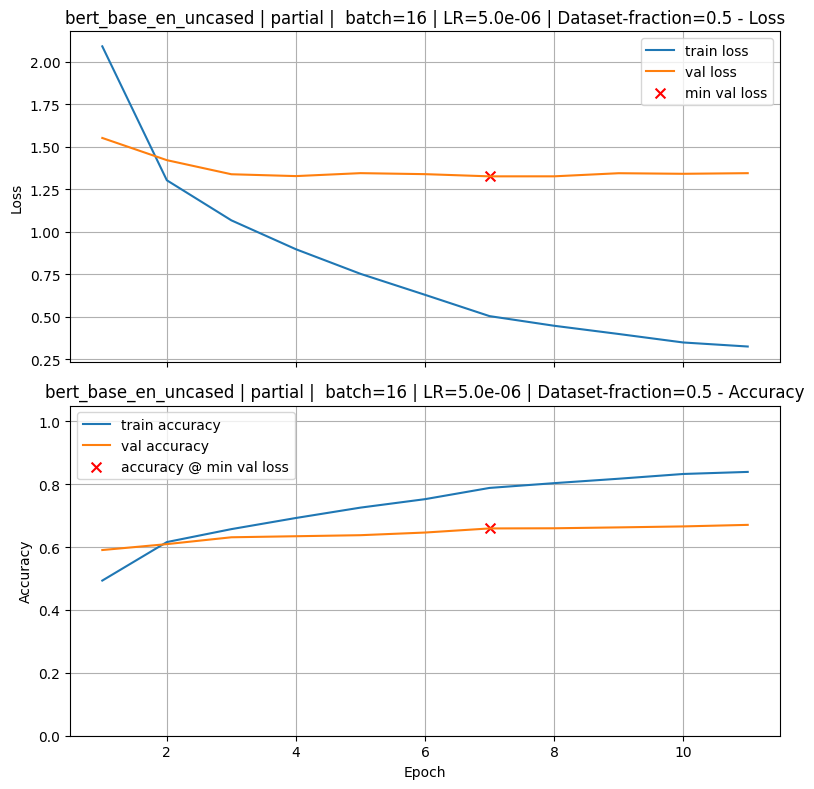

Final Training Loss:            0.3256
Final Training  accuracy:    0.8389
Final Validation Loss:          1.3453
Final Validation  accuracy:  0.6705
Min Validation Loss:            1.3267 (Epoch 7)
Accuracy @ Min Val Loss:      0.6592

Test metrics:
  loss: 1.3174
  accuracy: 0.6569

Execution Time: 30m 31s
Peak Memory Usage: 24165.62 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=16 | LR=5.0e-06 | Dataset-fraction=0.5 | Time=30m 31s | Mem=24165.62MB
  best_epoch_by_val_loss: 7
  min_val_loss: 1.3266676664352417
  accuracy_at_min_val_loss: 0.6591684818267822
  made_internal_val: False
  test_metrics: {'loss': 1.317359447479248, 'accuracy': 0.6569420099258423}
  train_time_sec: 1831.3917951583862
  peak_memory_mb: 24165.62109375
Test accuracy (from summary): 0.6569
Test macro-F1 (recalculated): 0.6083


--------------------------------------------------------------------------------
Running: model=bert_base_en_uncased  batch=16  lr=2.0e-06  strategy=partial
------

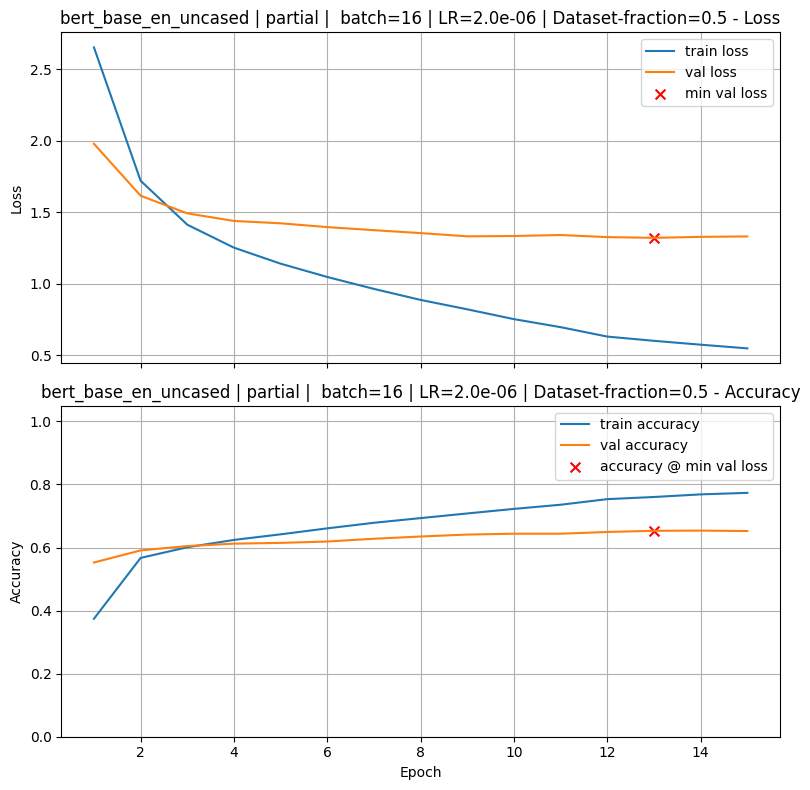

Final Training Loss:            0.5464
Final Training  accuracy:    0.7734
Final Validation Loss:          1.3299
Final Validation  accuracy:  0.6522
Min Validation Loss:            1.3199 (Epoch 13)
Accuracy @ Min Val Loss:      0.6530

Test metrics:
  loss: 1.3094
  accuracy: 0.6527

Execution Time: 38m 53s
Peak Memory Usage: 25503.54 MB

Summary of run:
  title: bert_base_en_uncased | partial |  batch=16 | LR=2.0e-06 | Dataset-fraction=0.5 | Time=38m 53s | Mem=25503.54MB
  best_epoch_by_val_loss: 13
  min_val_loss: 1.3198720216751099
  accuracy_at_min_val_loss: 0.6530427932739258
  made_internal_val: False
  test_metrics: {'loss': 1.309387445449829, 'accuracy': 0.6527240872383118}
  train_time_sec: 2333.174626350403
  peak_memory_mb: 25503.5390625
Test accuracy (from summary): 0.6527
Test macro-F1 (recalculated): 0.6030



==== Experiment Loop for subset_frac=0.5 complete ====



In [73]:
# lets find model performance with lr  1e-6, 5e-6


#Execute with fraction = 0.5 as we are gitting similar perfromance even with larger data (i.e 0.75 and 1) but we are having smuch lower trianing time

subset_frac = 0.5
current_results, current_subset_stats = run_experiment_loop(
        current_subset_frac = subset_frac,
        model_configs_list = ALL_MODEL_CONFIGS, # Use the globally defined model configurations
        max_epochs = EPOCHS,
        n_partial_layers = N_PARTIAL_LAYERS,
        eval_batch_size = 16,
        all_dataset = all_ds,
        num_classes_global = num_classes,
        label_names_global = label_names,
        class_weights_global = class_weights,
        use_reduce_lr = True ,
        patience = 4                 #doing reduced patience so as the reduced lr kicks in
    )
all_experiment_results.update(current_results)
all_subset_stats.extend(current_subset_stats)

In [75]:
print("\n\n==== OVERALL AGGREGATED EXPERIMENT SUMMARY ====\n")

# Display overall results table from 'all_subset_stats'
try:
    summary_df = pd.DataFrame(all_subset_stats)
    # Sort by test_f1_macro for better comparison
    summary_df = summary_df.sort_values(by="test_f1_macro", ascending=False)
    display(summary_df)
except Exception as e:
    print(f"Could not display full summary table: {e}")
    for entry in all_subset_stats:
        print(entry)

print("\nAll experiments complete.")



==== OVERALL AGGREGATED EXPERIMENT SUMMARY ====



,model,strategy,batch,lr,val_acc_at_min_loss,min_val_loss,test_loss,test_acc,test_f1_macro,elapsed_sec,peak_memory_mb,dataset_fraction
19,bert_base_en_uncased,partial,16,0.000010,0.652785,1.245652,1.234931,0.654894,0.609215,1768.004436,22192.964844,0.75
21,bert_base_en_uncased,partial,16,0.000005,0.659168,1.326668,1.317359,0.656942,0.608333,1831.391795,24165.621094,0.50
20,bert_base_en_uncased,partial,16,0.000010,0.651368,1.215781,1.207051,0.652573,0.605826,2009.841954,23167.753906,1.00
18,bert_base_en_uncased,partial,16,0.000010,0.658164,1.294546,1.299063,0.652724,0.604249,1333.608710,21243.378906,0.50
22,bert_base_en_uncased,partial,16,0.000002,0.653043,1.319872,1.309387,0.652724,0.603006,2333.174626,25503.539062,0.50
14,bert_base_en_uncased,full,16,0.000010,0.638052,1.391978,1.434093,0.642481,0.574336,423.394450,17054.316406,0.10
13,bert_base_en_uncased,partial,16,0.000010,0.650100,1.372191,1.447077,0.641225,0.572350,431.310800,15796.992188,0.10
16,bert_base_en_uncased,partial,32,0.000010,0.645582,1.372590,1.425388,0.644740,0.571628,387.302646,18585.179688,0.10
10,bert_base_en_uncased,partial,8,0.000010,0.625502,1.378623,1.468031,0.621642,0.558829,495.220237,12668.929688,0.10
4,distil_bert_base_en_uncased,partial,16,0.000010,0.644076,1.367169,1.465619,0.624153,0.556265,259.731698,8056.957031,0.10



All experiments complete.


In [76]:

print_results(results)

Sorting results by: accuracy_at_min_val_loss

bert_base_en_uncased | partial |  batch=16 | LR=5.0e-06 | Dataset-fraction=0.5  0.6592  (best epoch=7)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.5  0.6582  (best epoch=4)
bert_base_en_uncased | partial |  batch=16 | LR=2.0e-06 | Dataset-fraction=0.5  0.6530  (best epoch=13)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.75  0.6528  (best epoch=3)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=1  0.6514  (best epoch=2)
bert_base_en_uncased | partial |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6501  (best epoch=6)
distil_bert_base_en_uncased | full |  batch=16 | LR=1.0e-05 | Dataset-fraction=0.1  0.6481  (best epoch=8)
bert_base_en_uncased | full |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6481  (best epoch=6)
bert_base_en_uncased | partial |  batch=32 | LR=1.0e-05 | Dataset-fraction=0.1  0.6456  (best epoch=7)
distil_bert_base_en_uncase

### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**

We selected BERT because it performed much better compared to DistilBERT. BERT, with either partial training (where only the last two layers were trained) or full training (meaning the entire backbone was trained), consistently outperformed the 'frozen' strategy. In the evaluation round of training and testing, the top six results all utilized BERT. Although BERT required slightly more training time compared to DistilBERT, for applications where classification accuracy and F1-Macro scores are critical, BERT is a better fit. That's why we chose to experiment more with BERT. Another reason for selecting BERT is its rich language information and the larger vocabulary it was pretrained on.



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it.

4.2. **Your answer here:**

Our fine-tuning strategy was guided by a balance between model performance (i.e., accuracy at minimum validation loss and Test F1 Macro) and infrastructure needs/cost. We recognized that infrastructure cost is directly proportional to training time and the memory required for training.

In the initial evaluation round, we performed a first level of tuning, where we compared three strategies: backbone freeze, partial freeze, and full backbone training. We observed that partial freezing yielded results comparable to full training (with full training performing slightly better).

Notably, the CPU and memory requirements for full training were substantially higher. We also investigated which batch sizes offered the best performance and found that batch sizes of 16 and 32 were among the top-performing configurations. We opted for a batch size of 16, anticipating better generalization when training with the full dataset.

Next, we attempted to tune the model with lower initial learning rates (specifically, 5e-06 and 2e-06) instead of the initial 1e-05. This was in addition to enabling the use_reduce_lr=True setting.

Given that the accuracy and F1-score did not significantly improve as the subset_fraction increased from 0.5 to 0.75 to 1.0, we decided to train with a 0.5 subset fraction but utilizing these newly identified lower learning rates.



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**

Problem 2 - Beseline Model accuracy_at_min_val_loss: 0.611398458480835 test_metrics: {'loss': 1.4069441556930542, 'accuracy': 0.6131057143211365} train_time_sec: 22.085371494293213 peak_memory_mb: 3412.359375

Problem 3 – Custom v2: BiLSTM Small Head and Dropout=0.2 accuracy_at_min_val_loss: 0.572432816028595 test_metrics: {'loss': 1.6100226640701294, 'accuracy': 0.5770022869110107} train_time_sec: 537.5913763046265 peak_memory_mb: 3725.109375

Problem 3 – Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool accuracy_at_min_val_loss: 0.5675621628761292 test_metrics: {'loss': 1.6224101781845093, 'accuracy': 0.5692694187164307} train_time_sec: 1073.4833145141602 peak_memory_mb: 3781.984375

Problem 3 – Custom Model 2: Embedding + SpatialDropout + BiLSTM + AttentionPooling accuracy_at_min_val_loss: 0.5422545671463013 test_metrics: {'loss': 1.7226115465164185, 'accuracy': 0.544564425945282} train_time_sec: 177.88028192520142 peak_memory_mb: 3855.01953125



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models.





4.4. **Your answer here:**

The **Baseline model** is the quickest with a small memory requirement, it also has the lowest computation time. So its ideal to do a quick evaluation of dataset to strategise the next steps.

We notice that the **training time of the Distilbert is smaller than the custom model.  Bert is higher than DistilBERT  but lower than the custom model** though it provides higher accuracy at minimal validation loss and test F1-Macro scores (i.e once we have identified the parameters needed).

The BERT model though needs higher training time time to arrive at the best parameters , it gives better accuracy metrics which is the main success criteria in classification.

**The Memory requirement for BERT is the highest and is nearly 5-6 times of the custom models. The DistilBert has about 3 times the memeory requirement compared to the custom model  and has lesser memory requirement compared to BERT**


Problem 2 - Beseline Model

train_time_sec: 22.085371494293213
peak_memory_mb: 3412.359375

Problem 3 – Custom v2: BiLSTM Small Head   and Dropout=0.2

train_time_sec: 537.5913763046265
peak_memory_mb: 3725.109375

Problem 3 – Custom v3: BiLSTM + SpatialDropout + Max+Avg Pool

train_time_sec: 1073.4833145141602
peak_memory_mb: 3781.984375

Problem 3 – Custom Model 2: Embedding + SpatialDropout + BiLSTM + AttentionPooling

train_time_sec: 177.88028192520142
peak_memory_mb: 3855.01953125


## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report.

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**

Based on the results dictionary and the summary_df from your execution, here's a clear quantitative comparison of your three model categories:

Quantitative Comparison of Models

Model Category	Validation Acc @ Min Loss	Test Accuracy	Test Macro-F1	Training Time (sec)	Peak Memory (MB)
Baseline Model	0.6114	0.6131	0.5485	22.09	3412.36
Best Custom Model	0.5724	0.5770	0.5184	537.59	3725.11
Best Pretrained Model	0.6592	0.6569	0.6083	1831.39	24165.62

(Note: For the 'Best Custom Model', we've used 'Custom v2 BiLSTM' as it shows the highest validation accuracy among your custom models, although it is still lower than the baseline.
For the 'Best Pretrained Model', we've used 'bert_base_en_uncased | partial | batch=16 | LR=5.0e-06 | Dataset-fraction=0.5', which demonstrated the highest validation accuracy at min loss among the fine-tuned BERT models.)

**Which model achieved the best overall results, and what factors contributed to its success?**

The Pretrained BERT model ('bert_base_en_uncased | partial | batch=16 | LR=5.0e-06 | Dataset-fraction=0.5') achieved the best overall results. It outperformed both the Baseline and Custom models across all key performance metrics:

Highest Validation Accuracy @ Min Loss: 0.6592
Highest Test Accuracy: 0.6569
Highest Test Macro-F1 Score: 0.6083

**Factors contributing to the succ of BERT model :**

Transfer Learning:  BERT is a large language model pre-trained on massive amounts of text data to learn deep linguistic patterns, context, and semantic relationships. We used transfer learning so we can customize it  or train it to our need based on the content we had in the dataset.

**Powerful Embeddings**: BERT is trained on very large vocabulary and it understands nuanced meaning of words due to large amount of context based usage for words that it got trained on. This helps in the overall classification accuracy.


**Architecture**: BERT's underlying Transformer architecture, has self-attention mechanism. Its effective at capturing long-range dependencies and complex interactions between words in a sequence. This is a significant advantage over simpler models like the Baseline (GlobalAveragePooling, which loses word order) or even the custom BiLSTM (which might still struggle with very long dependencies).

**Fine-tuning Strategy**: The chosen partial fine-tuning strategy allowed the model to adapt its pre-trained knowledge to the specific nuances of your HuffPost dataset while leveraging the general features learned during pre-training. Optimizing the learning rate (e.g., 5.0e-06) further refined this adaptation, leading to better convergence and performance compared to the faster, higher learning rates that might destabilize pre-trained weights.

**Robustness to Imbalance:** While class weights were applied to all models, BERT's feature extraction capabilities likely made it perfrom better in learning meaningful representations even for minority classes. This may have contributed to higher  Macro-F1 score compared to the other models.


2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**


**The Pretrained BERT model achieved the best overall results in terms of accuracy. Its success is attributed to the powerful transfer learning capabilities and its flexibility that it can be used for different application**.Incase we need a quick understanding of data and strategy the baseline model will work fine too, so depending on what we want to achieve either of them ie BERT or the baseline model can be a potent tool.

BERT model is much more costly to train and has much larger infra requirements compared to the baseline model, hence this is costlier model to train though has higher accuracy comapred to other models trained and tested.

Baseline model is the lowest in complexity and perfromed reasonably well. The more complicated models did not help as explained below :

Balance: Offers the best accuracy but at a significant computational cost. Since training is done less frequently so depending on the critcality of application (i.e need higher F1scores) this could work fine as long as the model can be used with reasonable infrastructure.

1. **Baseline Model (Embedding + GlobalAveragePooling)**:

Complexity: Low. This is a very simple architecture.
Accuracy: Moderate. It achieved a validation accuracy of 0.6114 and a test macro-F1 of 0.5485.
Efficiency: High. It was the fastest to train (around 22 seconds) and had the lowest memory footprint (around 3.4 GB).
Balance: Excellent for a quick benchmark.

2. **Custom Models (e.g., BiLSTM variants):**

Complexity: Medium. These models had increased specialized laeyrs/components like BiLSTMs, SpatialDropout, and attention which increasing the architectural complexity compared to the baseline.

Accuracy: These models performed worse than the baseline. The best custom model (BiLSTM with small head) achieved a validation accuracy of 0.5724 and a test macro-F1 of 0.5184 while other custom models perfromed worse.

Efficiency: Much lower than the efficeincy of the baseline model. The training times ranged from 177 seconds to over 1000 seconds (around 18 minutes), and peak memory usage was slightly higher (around 3.7-3.8 GB) than the baseline.

So we need to think through properly as to what kind of architectural change will help us in text classification. This is something we can work in future too.

3. **Pretrained Model (BERT, partial fine-tuning on full dataset):**

Complexity: High. Leveraging a large pre-trained BERT backbone, even with partial fine-tuning, means a significantly more complex model with a vast number of parameters.

Accuracy: Highest. This model achieved the best performance, with a validation accuracy of 0.6514 and a test macro-F1 of 0.6058. This is a noticeable improvement over the baseline.

Efficiency: Lowest. This model required substantially more resources. Training on the full dataset took approximately 2009 seconds (around 33.5 minutes) and peaked at around 23.1 GB of memory, making it the most demanding in terms of computational resources.






3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**

The most challenging classes had two common patterns
Low number of data in those category
Another category having similar name but didnt get flagged in cosine similarity

**Below are the record count by each category available in the dataset**:
- POLITICS: 32447
- FIFTY: 29101
- ENTERTAINMENT: 17125
- PARENTING: 12530
- TRAVEL: 9842
- STYLE & BEAUTY: 9491
- FOOD & DRINK: 8305
- QUEER VOICES: 6285
- BUSINESS: 5894
- THE WORLDPOST: 5839
- COMEDY: 5001
- SPORTS: 4857
- BLACK VOICES: 4514
- HOME & LIVING: 4159
- GOOD NEWS: 4047
- ENVIRONMENT: 3916
- ARTS: 3850
- WEDDINGS: 3651
- DIVORCE: 3423
- CRIME: 3393
- WOMEN: 3363
- MEDIA: 2807
- WORLDPOST: 2536
- RELIGION: 2523
- STYLE: 2216
- SCIENCE: 2169
- TECH: 2029
- MONEY: 1706
- COLLEGE: 1136
- EDUCATION: 991

**The most challenging classes had two common patterns**
- Low number of data in those category
- Another category having similar name but didnt get flagged in cosine similarity

**Challenging Classes- Below are the categories having lower F1 score**
Corresponding F1 score  (only picked where F1 is on or below0.40x)

     BUSINESS                        F1 = 0.3791 (total record 5894)
   
     COLLEGE                         F1 = 0.3508 (total record 1136)

     EDUCATION                       F1 = 0.3324 (total record 991)

     GOOD NEWS                       F1 = 0.3208 (total record 4047)

     SCIENCE                         F1 = 0.4000 (total record 2169)

     STYLE                           F1 = 0.3994 (total record 2216)

     TECH                            F1 = 0.4014 (total record 2029)

     WOMEN                           F1 = 0.2557 (total record 3363)

     WORLDPOST                       F1 = 0.3526 (total record 2536)


     STYLE has similarity with STYLE & BEAUTY in the name but didnt get captured in high TF-IDF similaroity score.

     Same for WORLDPOST similar to  THE WORLDPOST , EDUCATION & COLLEGE

     Incase more records were there it may have perfromed better as the model would have understoood the features better





4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model.


5.4 **Your answer here:**

We will continue to use BERT as it looks pretty powerfull. Will like to get a better understanding of how to train these quickly  and the same time have the improved accuracy in classification jobs.

What are other hyper parameters that we need to know on these language models so as we can have increased accuracy.

Improve on scanning the hyperparameter space so we can spend more on model finetuning

We would like to  try other language models and figure out how they fit to different classification  needs.  


### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**

a) What are the best practices in tunning pretrained model like BERT

b) Best Practices in using pretrained model for transfer learning and do we need to use any embedding system or are there preprocessors specific to these pretrained models

c)what are good learning rates used for training a pretrained model like BERT

d) How to get memory used in Linux system through ipython notebook

e) What are the key tips in using ReduceLROnPlateau

f) What are the batch size considerations while training an language model like BERT and pros and cons of the batch sizes
